# Instalar libs


In [1]:
!uv add matplotlib matplotlib-inline pandas scikit-learn seaborn xgboost lightgbm catboost imbalanced-learn mlflow hyperopt pyspark==3.5.6

Resolved 127 packages in 2ms
Audited 94 packages in 0.36ms


# Importar bibliotecas


In [45]:
import warnings
import random
import mlflow
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)
from hyperopt import hp, fmin, tpe, SparkTrials, Trials, STATUS_OK 
from sklearn.ensemble import RandomForestClassifier

# from sklearn.svm import SVC # removendo svm por não ser bom em problemas de classificação binária com dados desbalanceados (conhecimento empírico)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Constantes e configs

Semente aleatória = 202505


In [3]:
SEED = 202505
DATASET_PATH = Path("bank-full.csv")

os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"

# spark envs ( windows only)
python_path = r"C:\Users\research\AppData\Local\Programs\Python\Python311\python.exe"
os.environ["PYSPARK_PYTHON"] = python_path
os.environ["PYSPARK_DRIVER_PYTHON"] = python_path


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    print(f"Seed set to: {seed}")


set_seed(SEED)
warnings.filterwarnings('ignore')
# mlflow.autolog()

Seed set to: 202505


In [4]:
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
mlflow.set_experiment(f"bank-marketing-classification-{current_datetime}")
print(f"Experiment set to: bank-marketing-classification-{current_datetime}")

2025/06/05 01:06:46 INFO mlflow.tracking.fluent: Experiment with name 'bank-marketing-classification-2025-06-05_01-06-44' does not exist. Creating a new experiment.


Experiment set to: bank-marketing-classification-2025-06-05_01-06-44


# Carregar dataset


In [5]:
df = pd.read_csv(DATASET_PATH, sep=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [6]:
# separacao entre treino e teste
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,services,married,secondary,no,749,yes,no,cellular,3,apr,121,2,-1,0,unknown,no
1,28,services,single,secondary,no,339,no,no,cellular,3,dec,350,1,182,1,success,yes
2,42,management,married,tertiary,no,0,yes,no,cellular,9,jul,98,1,-1,0,unknown,no
3,42,admin.,married,secondary,no,323,yes,yes,unknown,8,may,280,2,-1,0,unknown,no
4,52,blue-collar,single,primary,no,210,yes,no,unknown,12,may,154,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,37,technician,married,secondary,no,3043,no,no,cellular,11,aug,123,4,-1,0,unknown,no
36164,40,technician,single,primary,no,340,yes,no,unknown,29,may,146,1,-1,0,unknown,no
36165,33,management,married,tertiary,no,968,no,yes,cellular,28,aug,95,10,-1,0,unknown,no
36166,52,blue-collar,married,secondary,no,594,no,no,telephone,29,jul,178,2,-1,0,unknown,no


# EDA


## Visualização básica do dataset


In [7]:
# tipos de variáveis, categorias, e valores únicos
print("Tipos de variáveis:")
display(df_train.dtypes.to_frame().T)
print("\nCategorias e valores únicos:")
for col in df_train.select_dtypes(include=["object"]).columns:
    print(f"{col}: {df_train[col].unique()}")

Tipos de variáveis:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,int64,object,object,object,object,int64,object,object,object,int64,object,int64,int64,int64,int64,object,object



Categorias e valores únicos:
job: ['services' 'management' 'admin.' 'blue-collar' 'technician' 'retired'
 'self-employed' 'unemployed' 'student' 'entrepreneur' 'housemaid'
 'unknown']
marital: ['married' 'single' 'divorced']
education: ['secondary' 'tertiary' 'primary' 'unknown']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['cellular' 'unknown' 'telephone']
month: ['apr' 'dec' 'jul' 'may' 'jan' 'oct' 'aug' 'nov' 'jun' 'feb' 'mar' 'sep']
poutcome: ['unknown' 'success' 'failure' 'other']
y: ['no' 'yes']


In [8]:
# valores ausente ('unknown') - qtde e porcentagem
print("\nValores ausentes ('unknown') - Quantidade e Porcentagem:")
unknown_counts = df_train.apply(lambda x: (x == "unknown").sum())
unknown_percentages = (unknown_counts / len(df_train)) * 100
unknown_df = pd.DataFrame(
    {"Quantidade": unknown_counts, "Porcentagem": unknown_percentages}
)
display(
    unknown_df[unknown_df["Quantidade"] > 0].sort_values(
        by="Quantidade", ascending=False
    )
)


Valores ausentes ('unknown') - Quantidade e Porcentagem:


,Quantidade,Porcentagem
poutcome,29527,81.638465
contact,10352,28.621986
education,1473,4.072661
job,238,0.658040


In [9]:
# informações estatísticas
print("\nInformações estatísticas:")
df_train.describe(include="all")


Informações estatísticas:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,36168.000000,36168,36168,36168,36168,36168.000000,36168,36168,36168,36168.000000,36168,36168.000000,36168.000000,36168.000000,36168.000000,36168,36168
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,7772,21735,18603,35525,NaN,20135,30380,23509,NaN,11068,NaN,NaN,NaN,NaN,29527,31899
mean,40.927809,NaN,NaN,NaN,NaN,1361.995825,NaN,NaN,NaN,15.846743,NaN,258.456619,2.755668,40.585877,0.584218,NaN,NaN
std,10.625543,NaN,NaN,NaN,NaN,3032.325115,NaN,NaN,NaN,8.318516,NaN,256.326620,3.106268,100.546774,2.396527,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,450.500000,NaN,NaN,NaN,16.000000,NaN,181.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1425.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


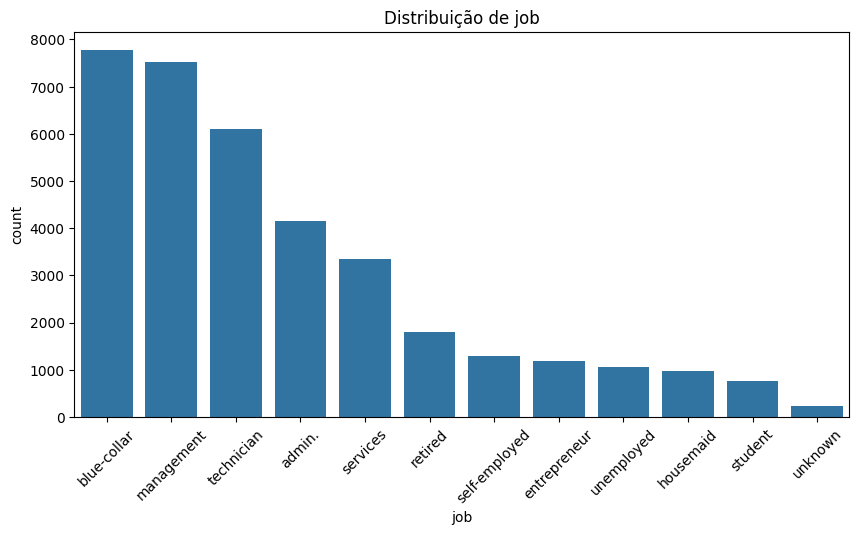

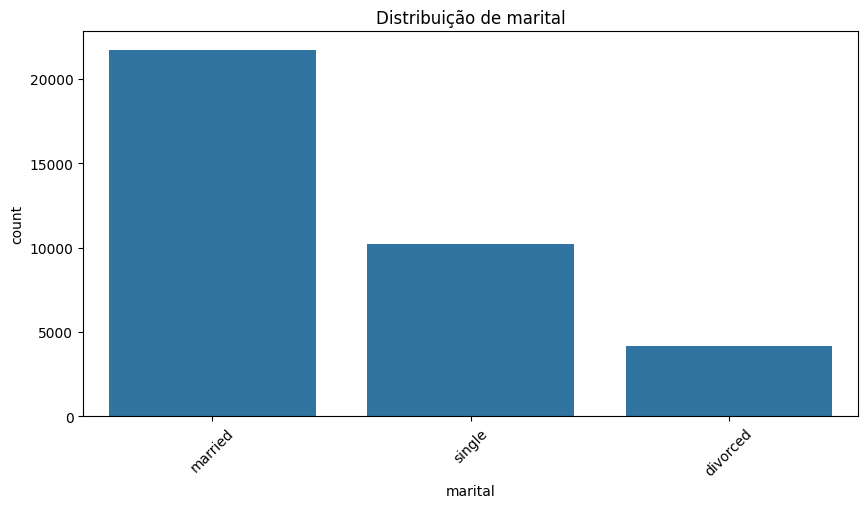

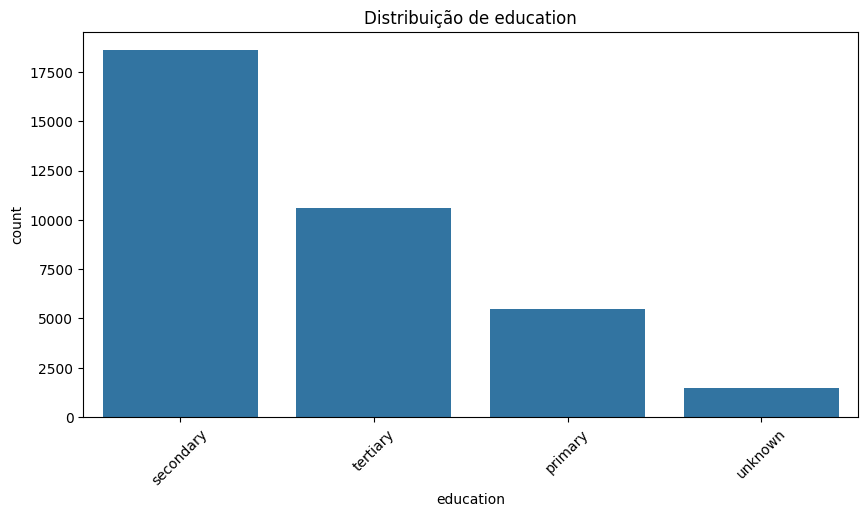

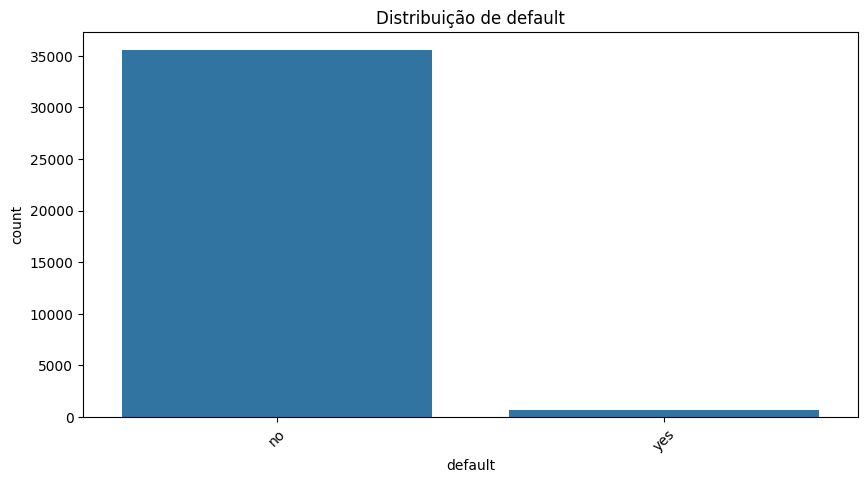

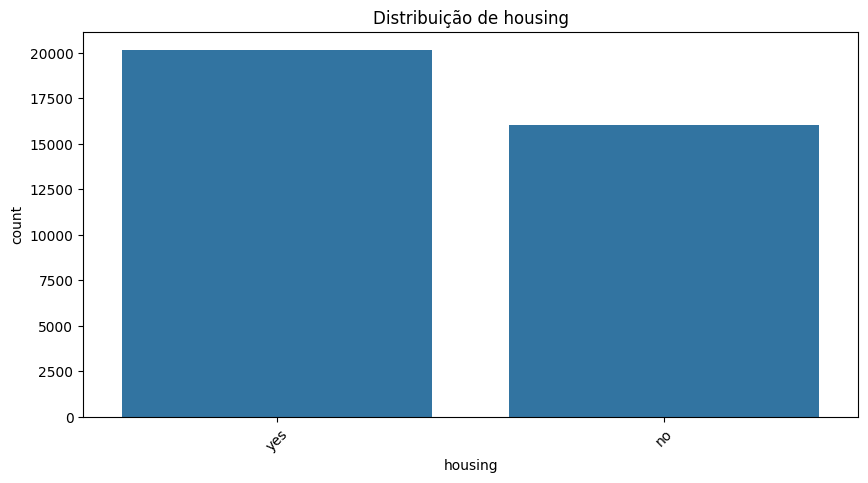

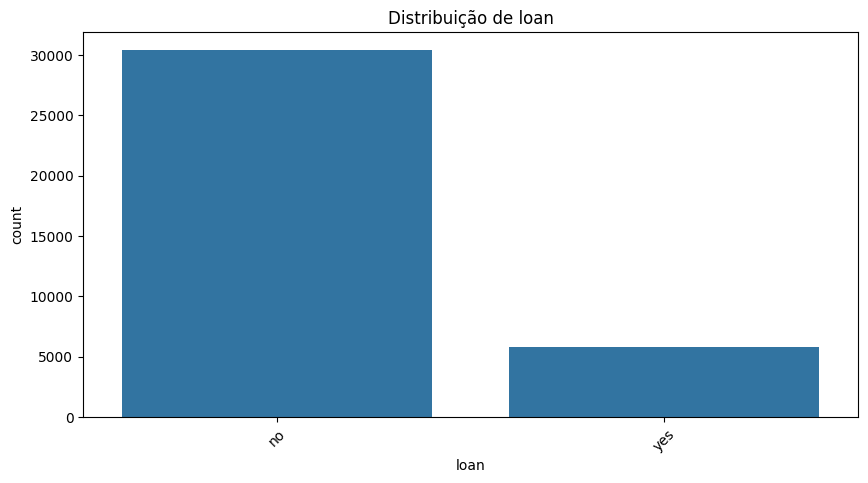

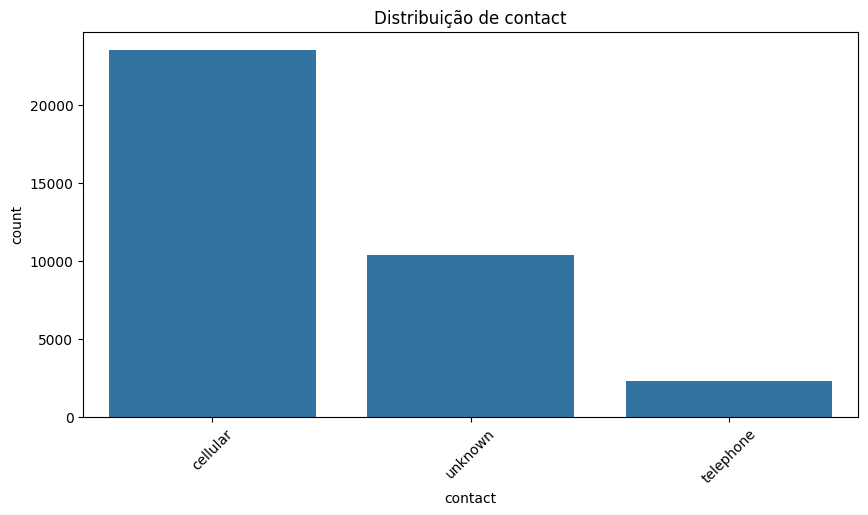

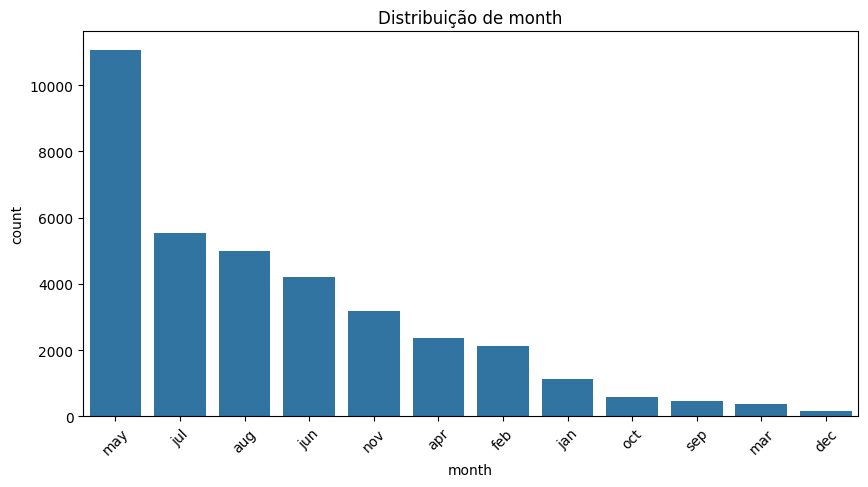

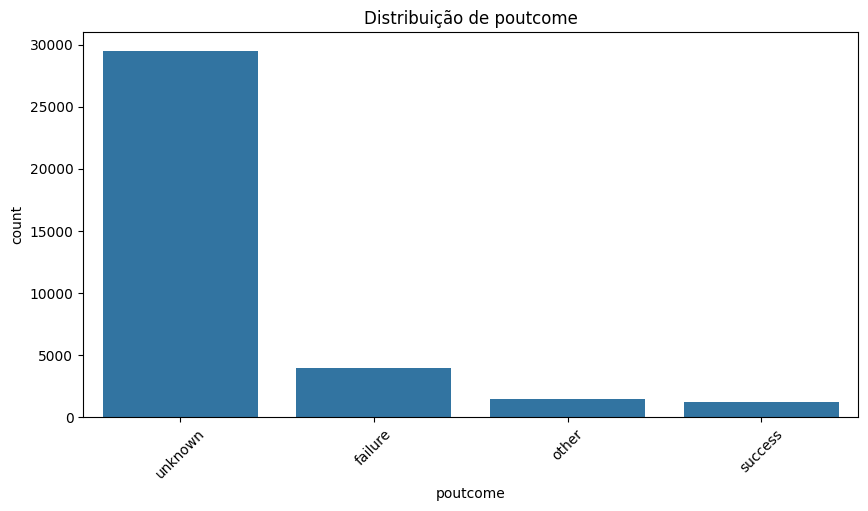

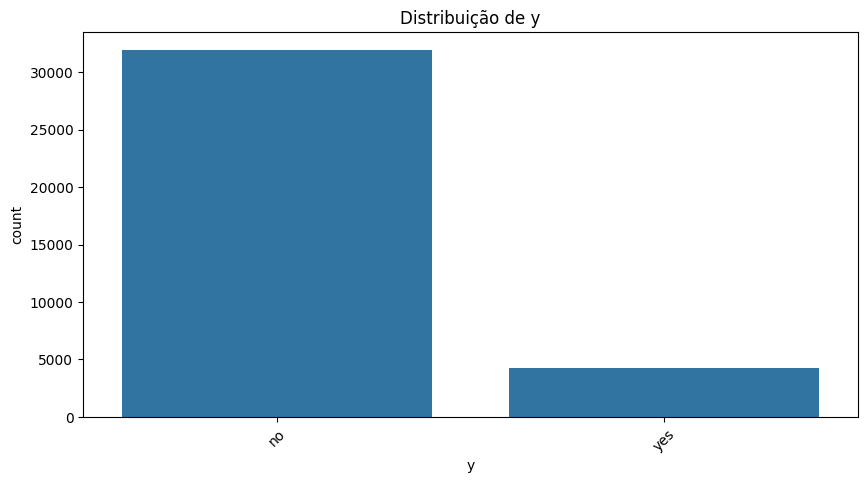

In [10]:
# Distribuição das variáveis categóricas
def plot_categorical_distribution(df: pd.DataFrame, column: str):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f"Distribuição de {column}")
    plt.xticks(rotation=45)
    plt.show()


categorical_columns = df_train.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    plot_categorical_distribution(df_train, col)

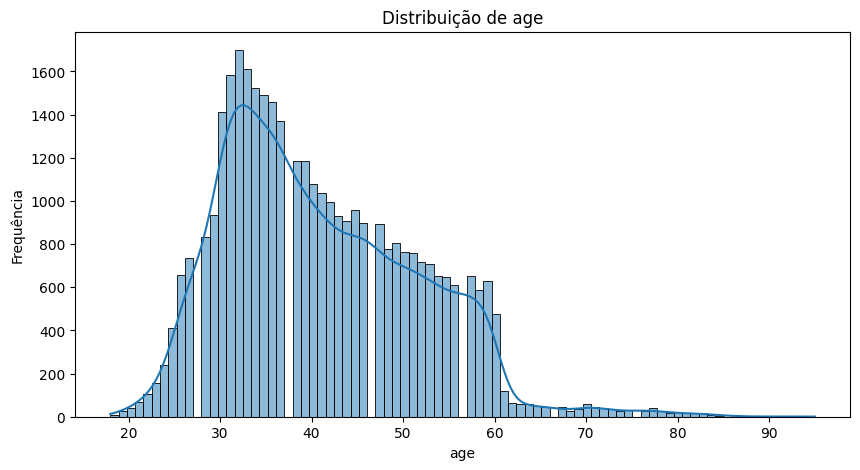

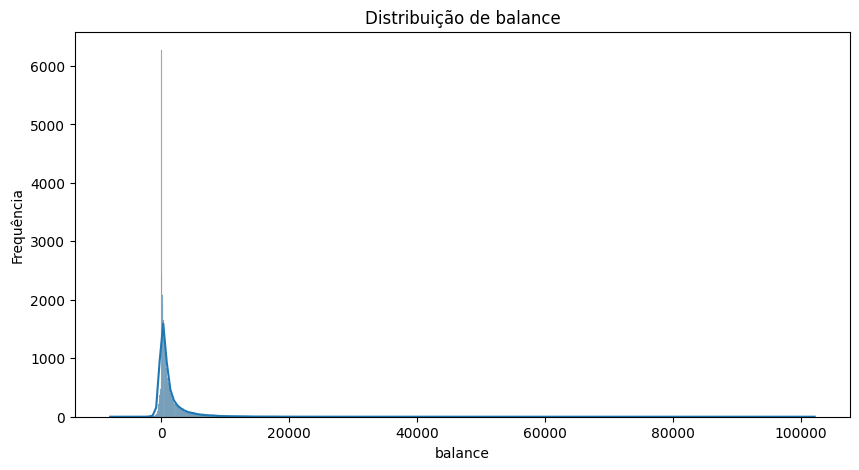

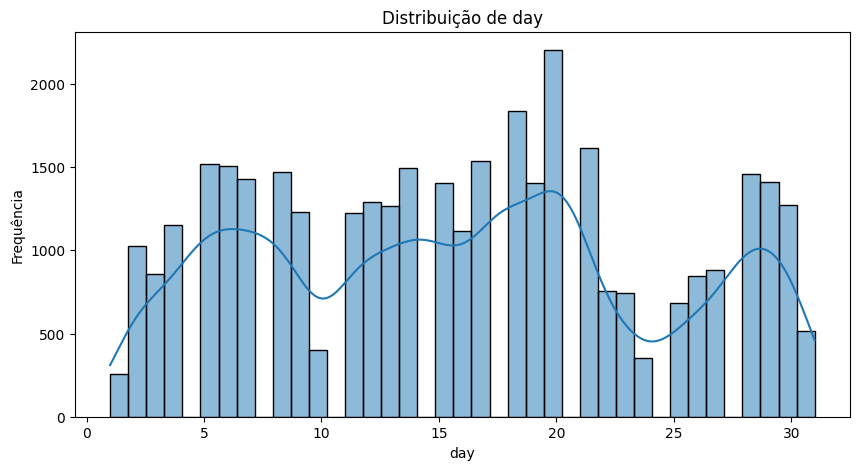

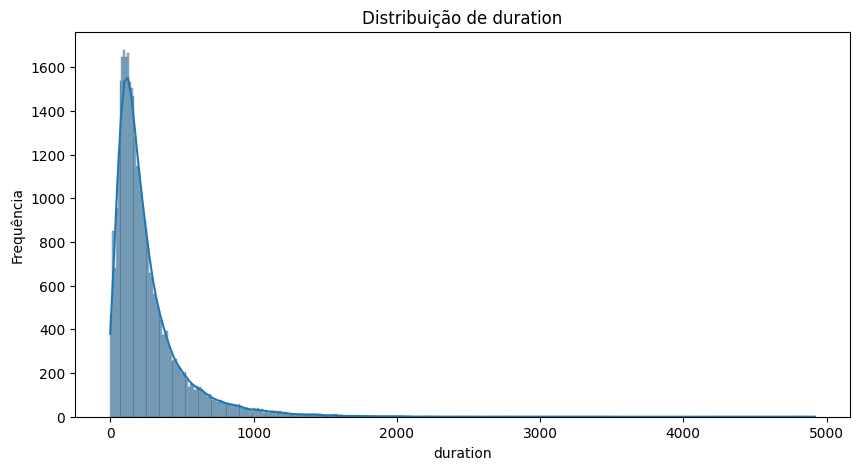

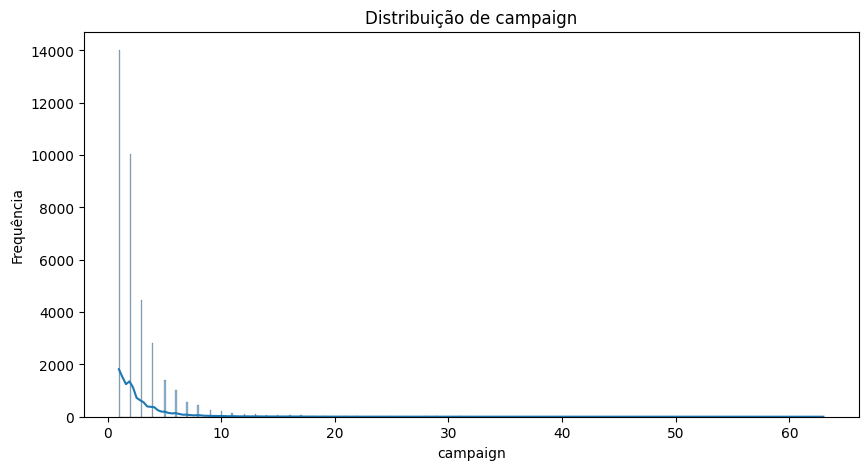

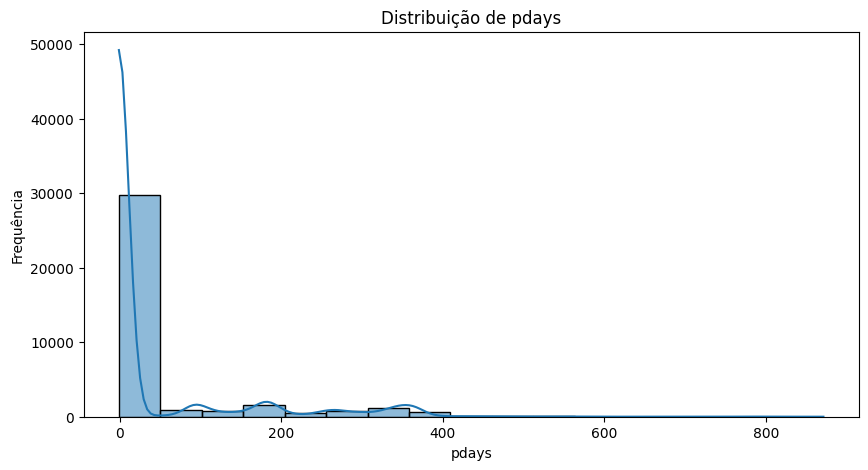

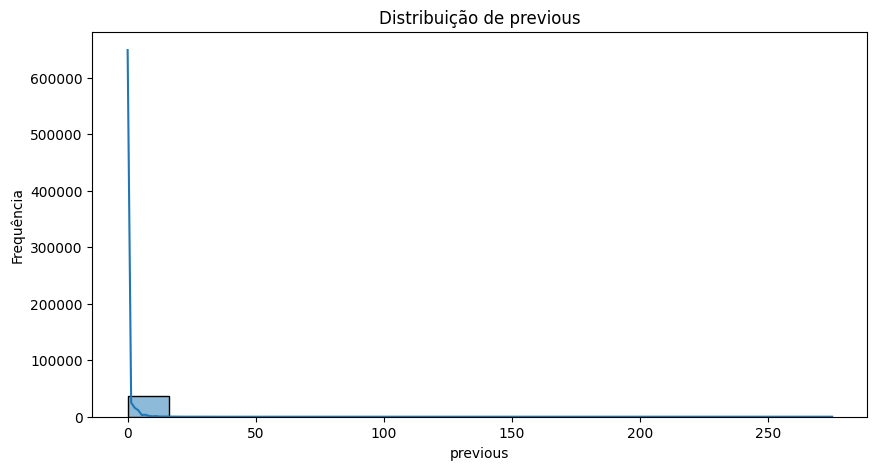

In [11]:
# Distribuilão das variáveis numéricas
def plot_numerical_distribution(df: pd.DataFrame, column: str):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribuição de {column}")
    plt.xlabel(column)
    plt.ylabel("Frequência")
    plt.show()


numerical_columns = df_train.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plot_numerical_distribution(df_train, col)

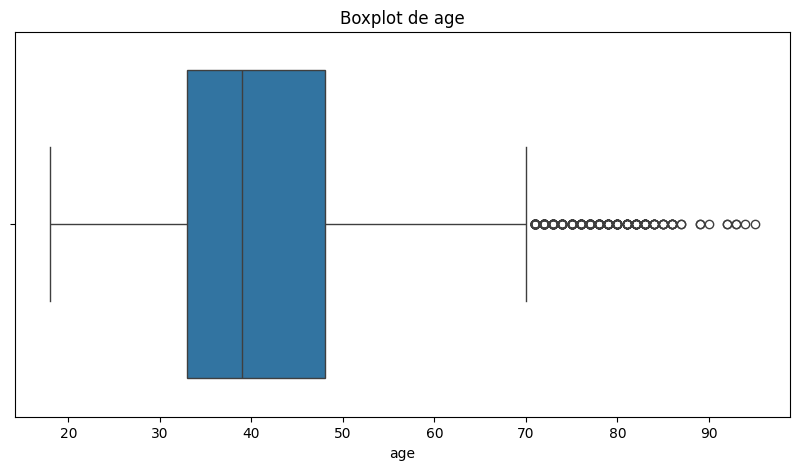

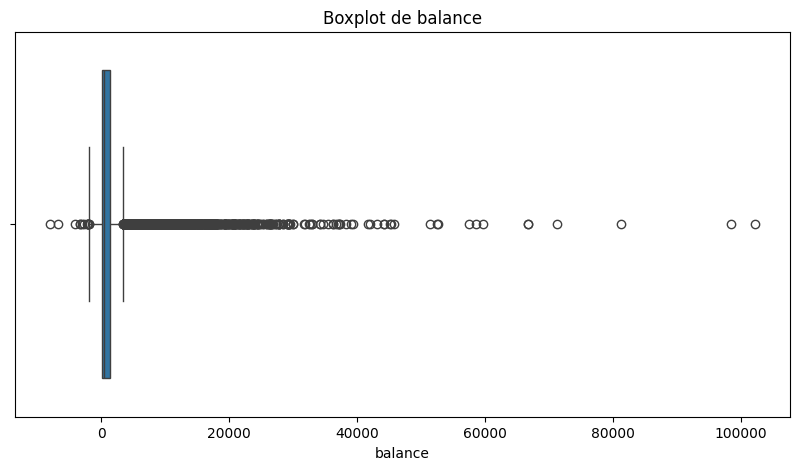

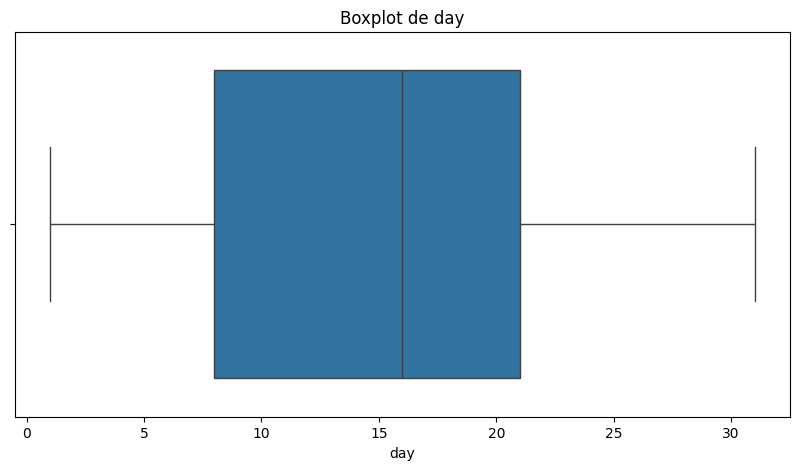

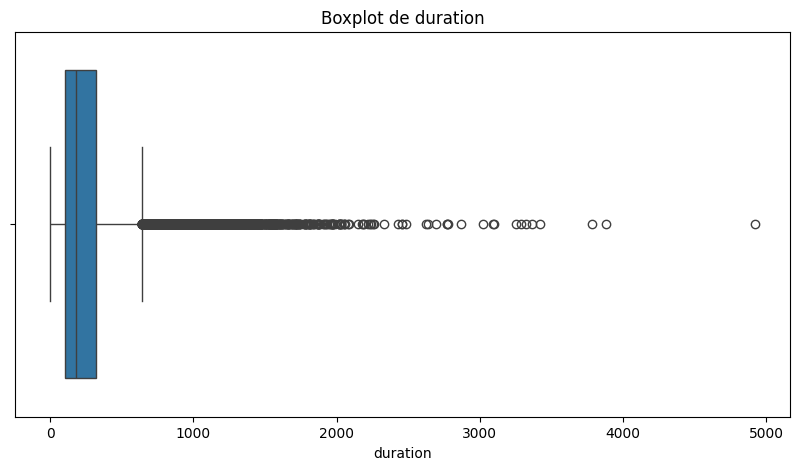

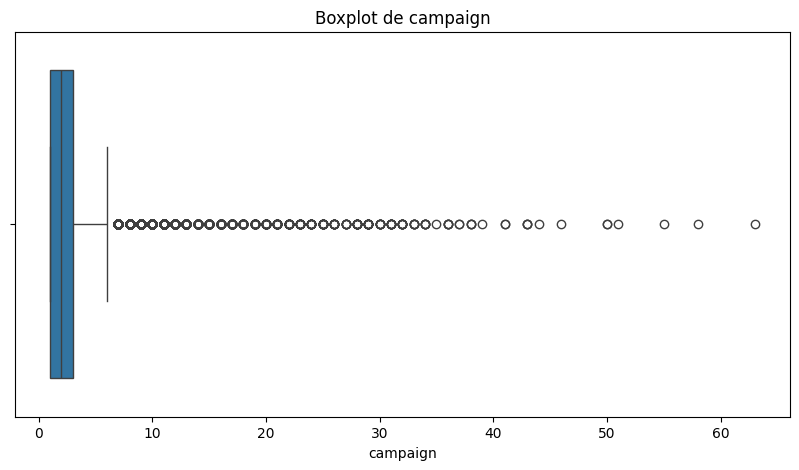

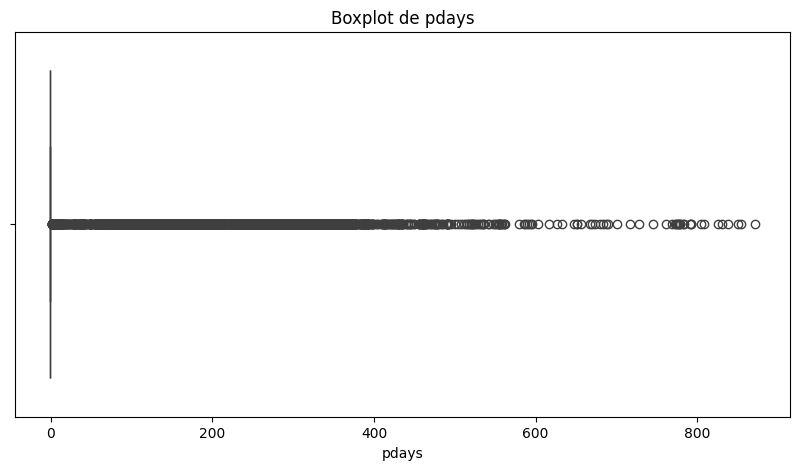

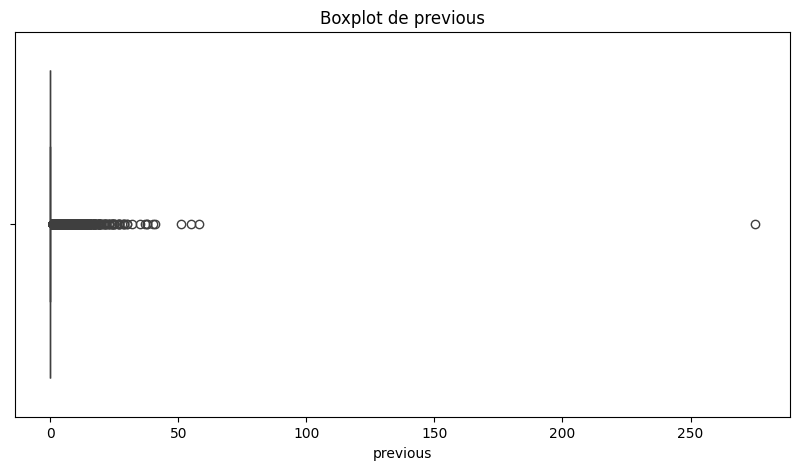

In [12]:
# boxplot para variáveis numéricas
def plot_boxplot(df: pd.DataFrame, column: str):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot de {column}")
    plt.xlabel(column)
    plt.show()


for col in numerical_columns:
    plot_boxplot(df_train, col)

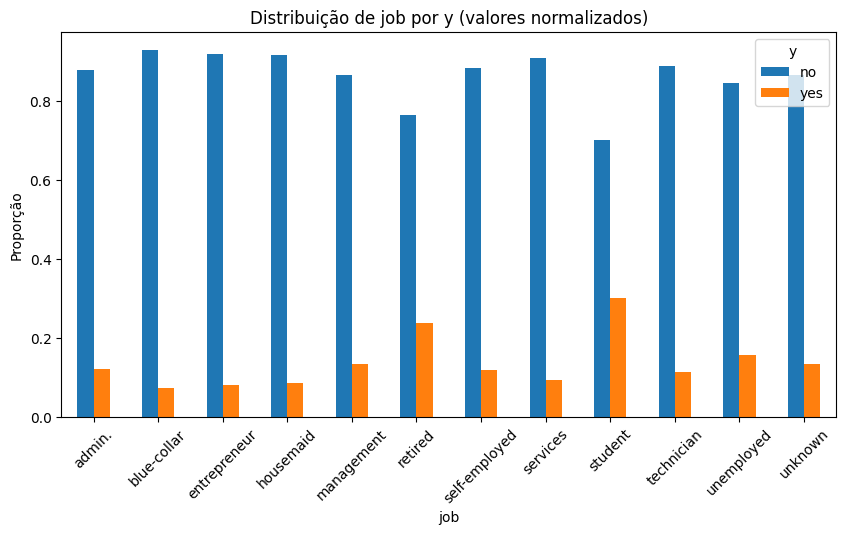

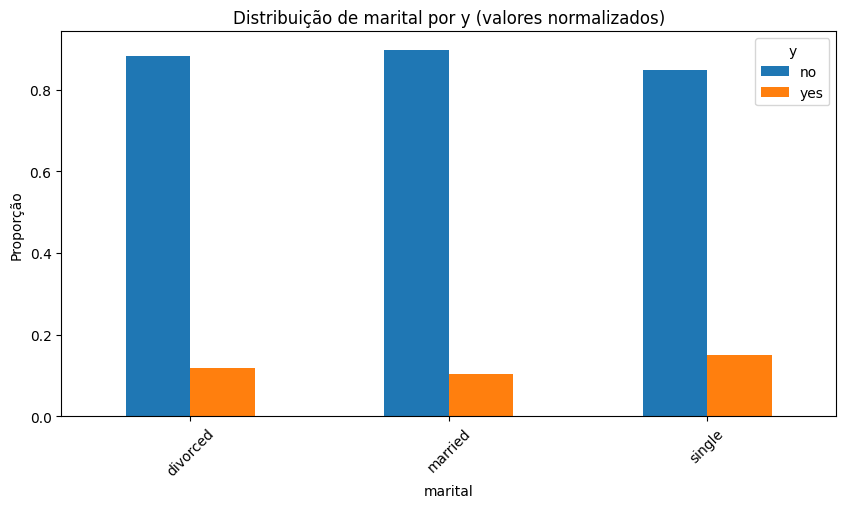

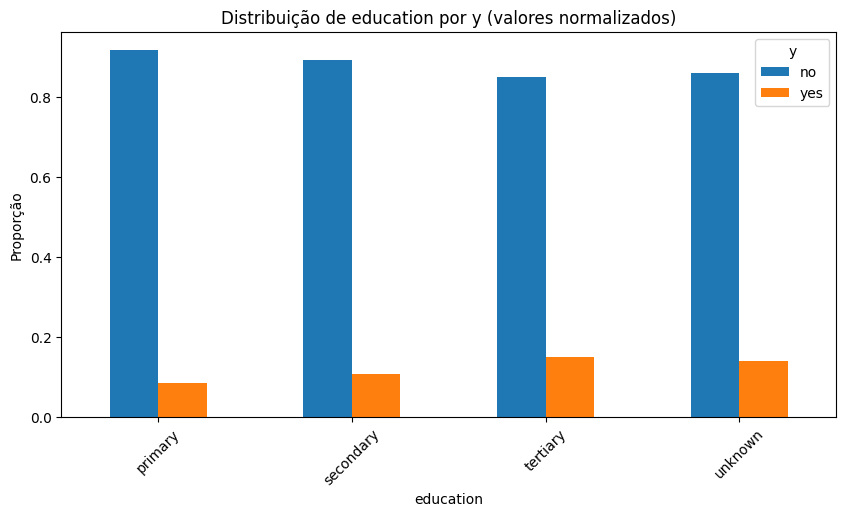

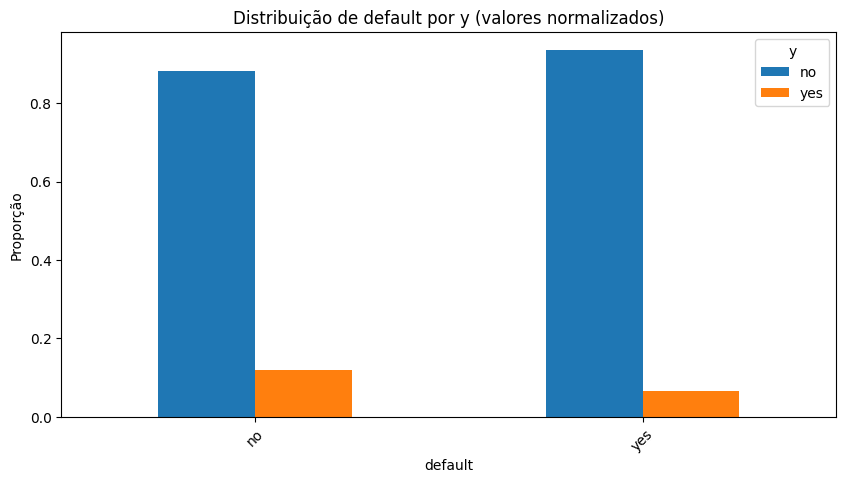

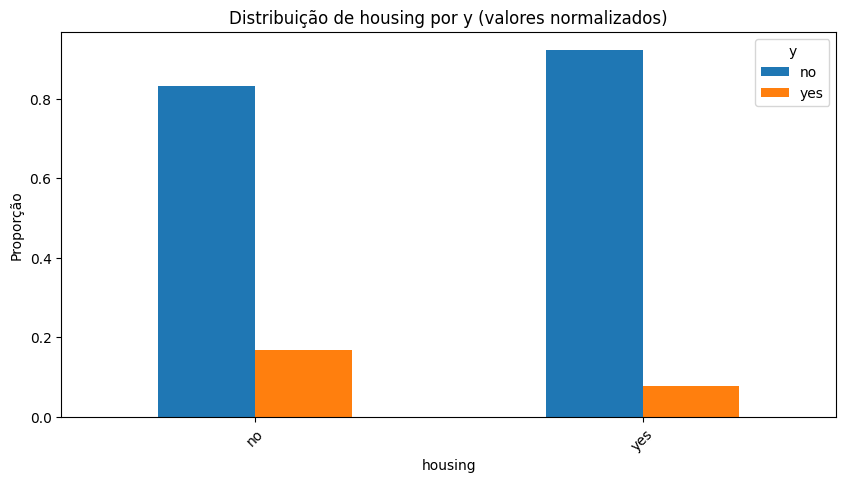

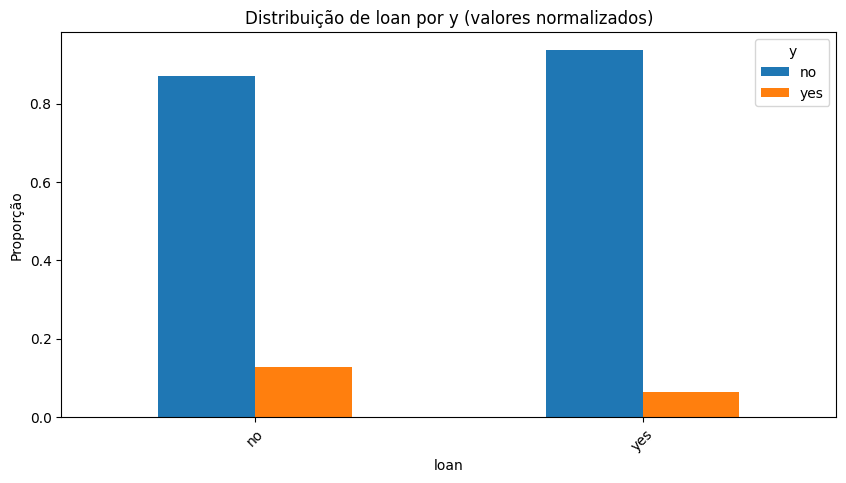

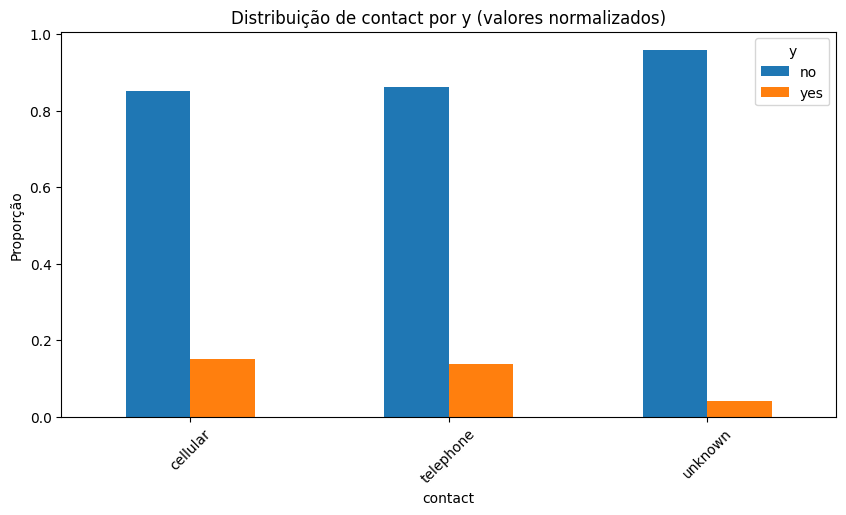

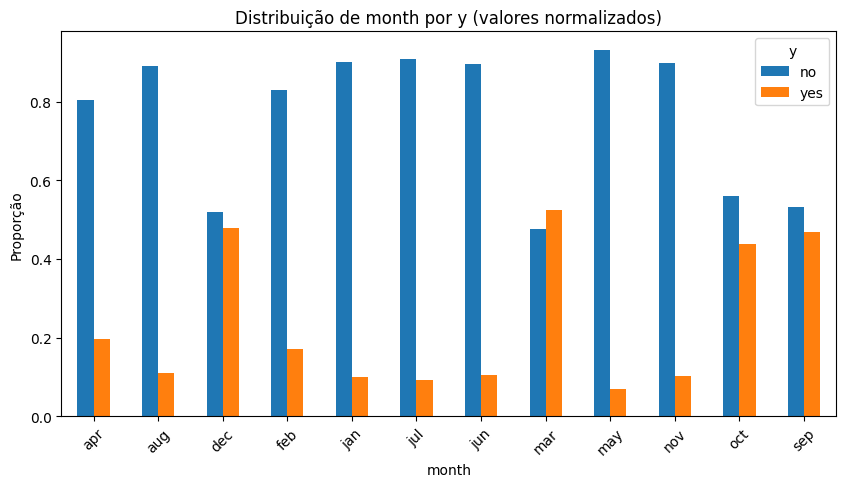

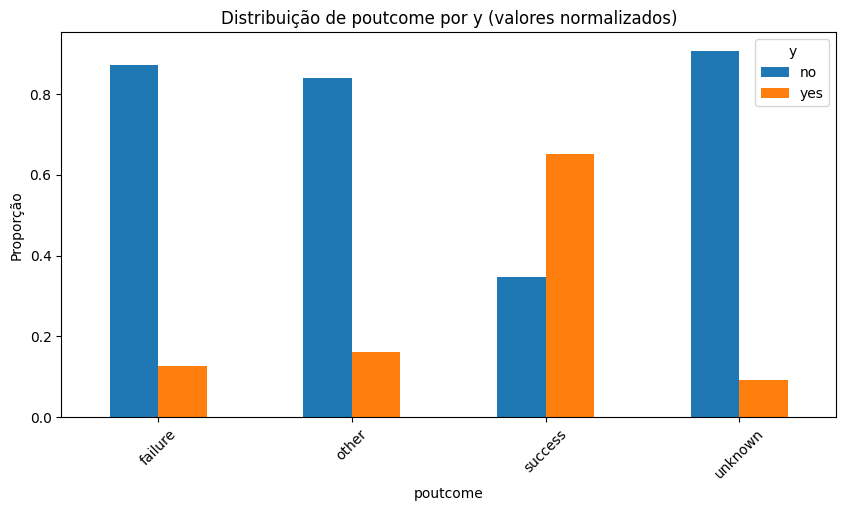

In [13]:
# Analise multivariada variaveis categóricas vs variável alvo (valores normalizados. Observacoes: dada a distribuicao de poutcome por y, parece que o fato do cliente ter aceitado a oferta de credito no passado (poutcome) influencia positivamente a aceitação da oferta atual.
def plot_categorical_vs_target(
    df: pd.DataFrame, categorical_column: str, target_column: str
):
    df_grouped = (
        df.groupby(categorical_column)[target_column]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )
    df_grouped.plot(kind="bar", figsize=(10, 5))
    plt.title(
        f"Distribuição de {categorical_column} por {target_column} (valores normalizados)"
    )
    plt.xlabel(categorical_column)
    plt.ylabel("Proporção")
    plt.legend(title=target_column)
    plt.xticks(rotation=45)
    plt.show()


target_column = "y"
for col in categorical_columns:
    if col != target_column:
        plot_categorical_vs_target(df_train, col, target_column)

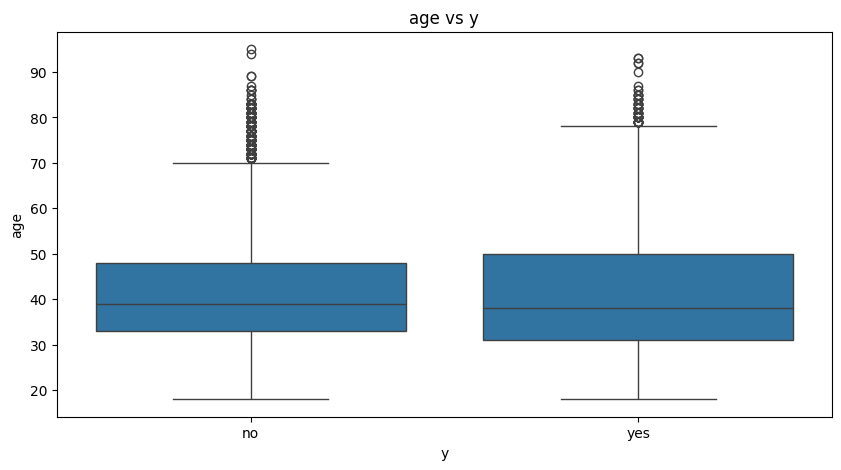

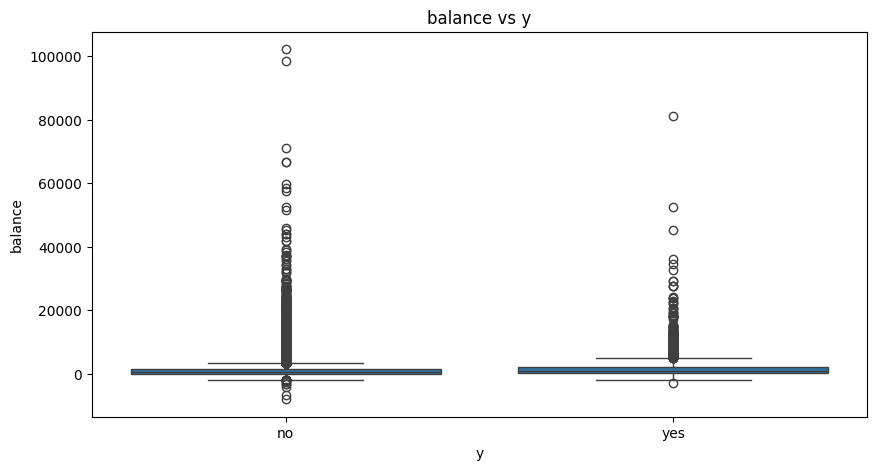

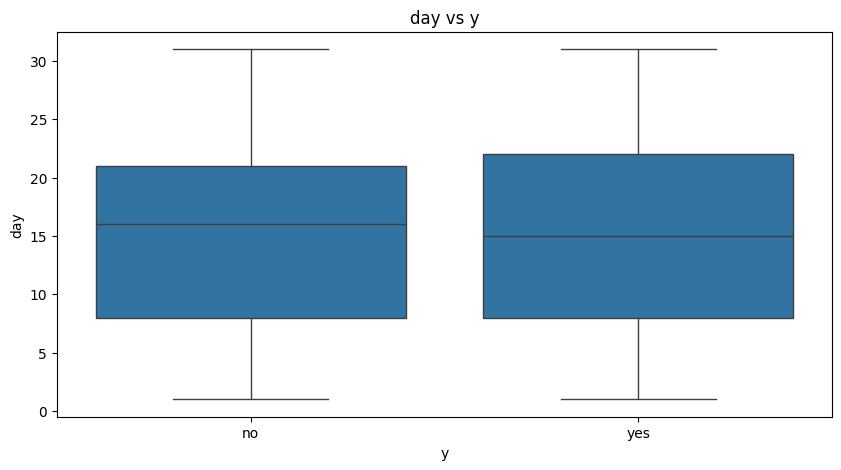

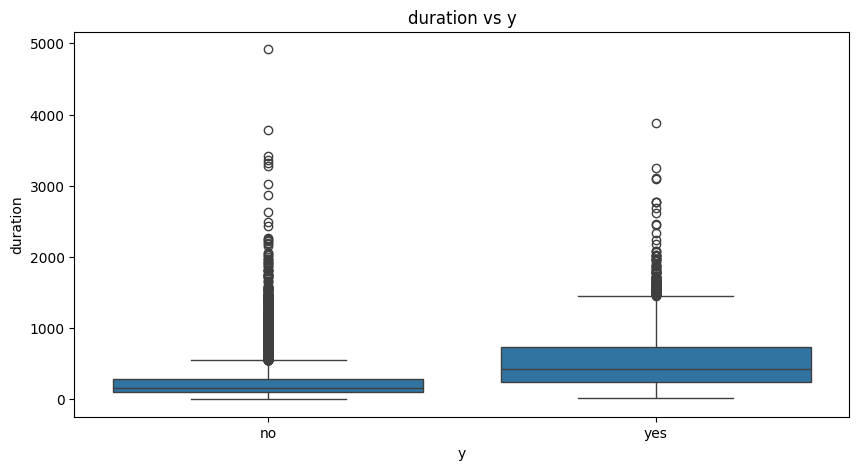

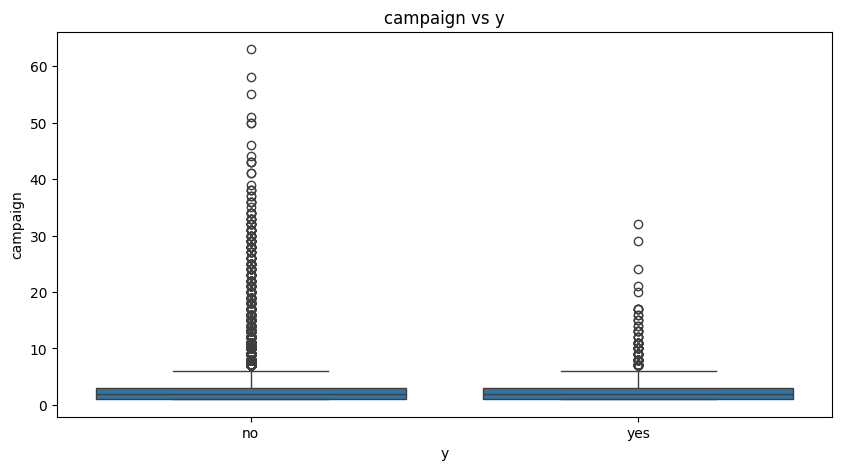

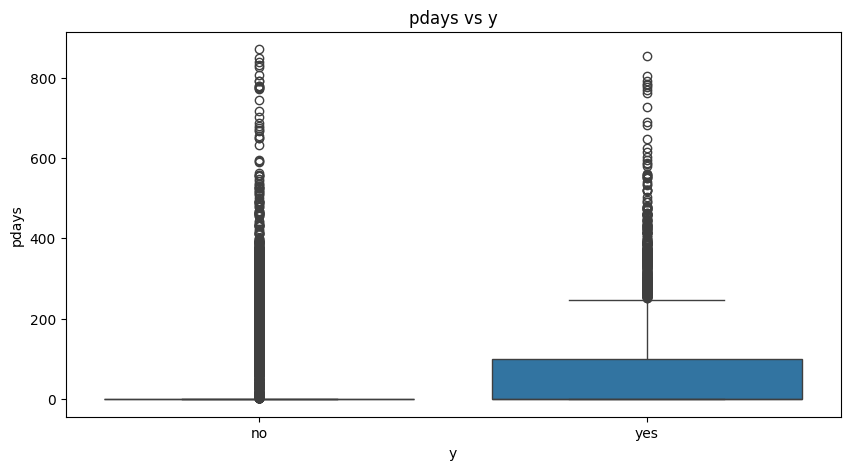

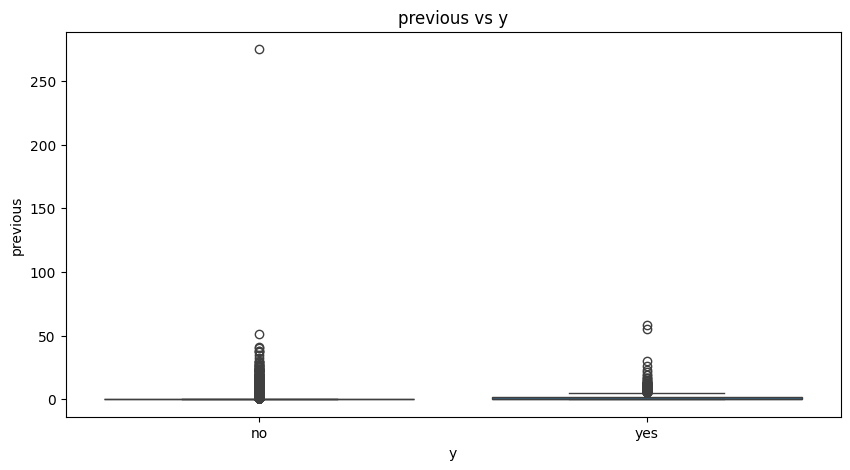

In [14]:
# analise multivariada variaveis numéricas vs variável alvo
def plot_numerical_vs_target(df, var, target="y"):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target, y=var, data=df)
    plt.title(f"{var} vs {target}")
    plt.xlabel(target)
    plt.ylabel(var)
    plt.show()


for col in numerical_columns:
    if col != "y":  # Excluindo a variável alvo
        plot_numerical_vs_target(df_train, col, target="y")

In [15]:
# codificação das variaveis categoricas binárias ( evitando codificar as variáveis categóricas com mais de 2 categorias para evitar vies de ordem)
def encode_binary_categorical(df: pd.DataFrame, column: str) -> pd.DataFrame:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df


binary_encoded_columns = []
df_encoded = df_train.copy()
for col in categorical_columns:
    if df_encoded[col].nunique() == 2:  # Verifica se é binária
        binary_encoded_columns.append(col)
        df_encoded = encode_binary_categorical(df_encoded, col)

print("\nVariáveis categóricas binárias codificadas:")
display(df_encoded[binary_encoded_columns].head())
df_encoded


Variáveis categóricas binárias codificadas:


,default,housing,loan,y
0,0,1,0,0
1,0,0,0,1
2,0,1,0,0
3,0,1,1,0
4,0,1,0,0


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,services,married,secondary,0,749,1,0,cellular,3,apr,121,2,-1,0,unknown,0
1,28,services,single,secondary,0,339,0,0,cellular,3,dec,350,1,182,1,success,1
2,42,management,married,tertiary,0,0,1,0,cellular,9,jul,98,1,-1,0,unknown,0
3,42,admin.,married,secondary,0,323,1,1,unknown,8,may,280,2,-1,0,unknown,0
4,52,blue-collar,single,primary,0,210,1,0,unknown,12,may,154,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,37,technician,married,secondary,0,3043,0,0,cellular,11,aug,123,4,-1,0,unknown,0
36164,40,technician,single,primary,0,340,1,0,unknown,29,may,146,1,-1,0,unknown,0
36165,33,management,married,tertiary,0,968,0,1,cellular,28,aug,95,10,-1,0,unknown,0
36166,52,blue-collar,married,secondary,0,594,0,0,telephone,29,jul,178,2,-1,0,unknown,0


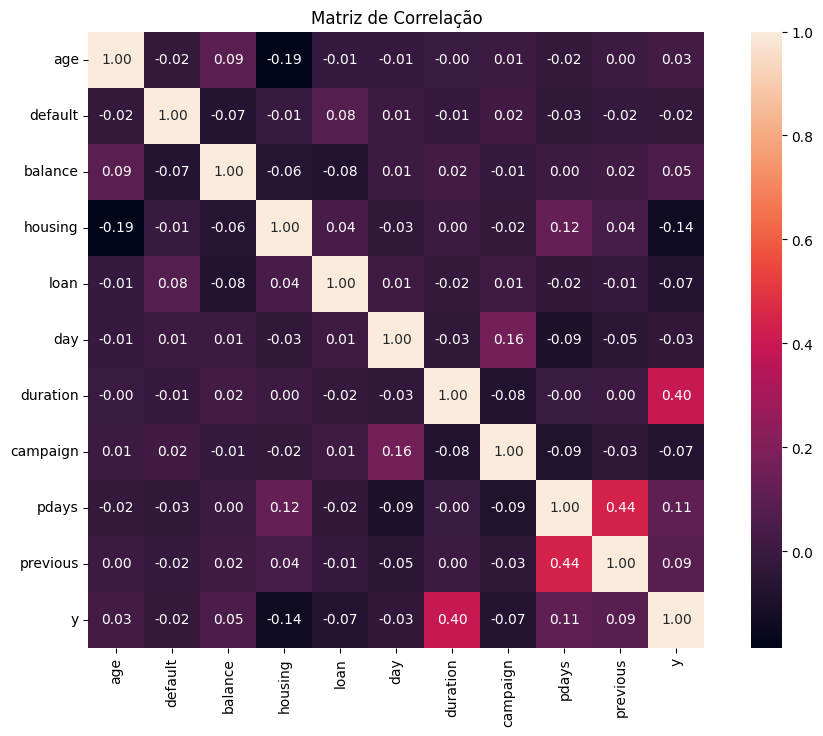

In [16]:
# Análise de correlação (variáveis numéricas). E possivel perceber que a variavel 'duration' tem uma correlação alta com a variável alvo 'y'. Vamos remover essa variavel do dataset, pois caso usassemos ela em um modelo de machine learning, o modelo teria acesso a informação que não estaria disponível no momento da predição. Detalhes: duration is the last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
def plot_correlation_matrix(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Matriz de Correlação")
    plt.show()


plot_correlation_matrix(df_encoded.select_dtypes(include=[np.number]))

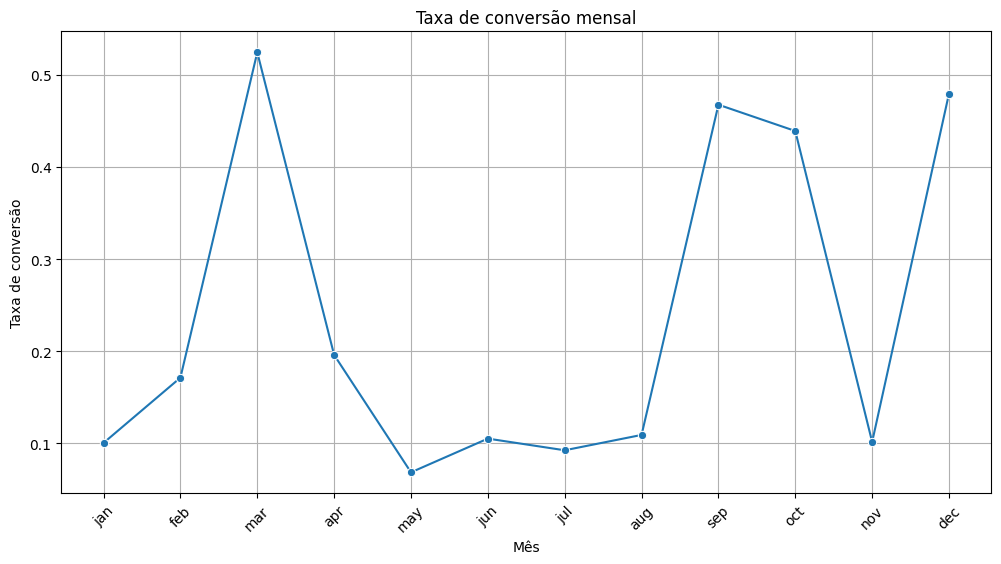

In [17]:
# Analise temporal (taxa de adesão ao longo do tempo - coluna 'month'). Normalizando o resultado para obter a taxa de adesão (proporção de 'yes' em relação ao total de contatos em cada mês). Pelos resultados, é possível observar que a taxa de adesão varia pouco ao longo dos meses, com picos significativos em marco, setembro, outubro e dezembro. Esses meses podem ser de maior interesse.
def plot_monthly_conversion_rate(df: pd.DataFrame, target="y"):
    monthly_counts = (
        df.groupby("month")[target].value_counts(normalize=True).unstack().fillna(0)
    )
    monthly_counts["conversion_rate"] = monthly_counts["yes"]

    # ordenar os meses
    months_order = [
        "jan",
        "feb",
        "mar",
        "apr",
        "may",
        "jun",
        "jul",
        "aug",
        "sep",
        "oct",
        "nov",
        "dec",
    ]
    monthly_counts = monthly_counts.reindex(months_order)

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=monthly_counts, x=monthly_counts.index, y="conversion_rate", marker="o"
    )
    plt.title("Taxa de conversão mensal")
    plt.xlabel("Mês")
    plt.ylabel("Taxa de conversão")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


plot_monthly_conversion_rate(df_train, target="y")

# Pré-processamento

O pré-processamento vai incluir a limpeza de dados, feature engineering e transformação de dados. Aplicados ao dataset de treino e teste.


In [18]:
# Pré-processamento básico dos dados
def remove_data_leakage_columns(
    df: pd.DataFrame, columns_to_remove: list
) -> pd.DataFrame:
    """Remove colunas que podem causar vazamento de dados."""
    df_cleaned = df.drop(columns=columns_to_remove, errors="ignore")
    print(f"Colunas removidas para evitar vazamento de dados: {columns_to_remove}")
    return df_cleaned


def encode_binary_categorical(df: pd.DataFrame) -> tuple[pd.DataFrame, list]:
    """Codifica todas as variáveis categóricas binárias usando Label Encoding."""
    le = LabelEncoder()
    binary_encoded_columns = []
    for col in df.select_dtypes(include=["object"]).columns:
        if df[col].nunique() == 2:  # Verifica se é binária
            df[col] = le.fit_transform(df[col])
            binary_encoded_columns.append(col)

    print(f"Variáveis categóricas binárias codificadas: {binary_encoded_columns}")
    return df, binary_encoded_columns


def encode_categorical_features(
    df: pd.DataFrame, nominal_columns: list, ordinal_columns: list
) -> pd.DataFrame:
    """Codifica variáveis categóricas nominais e ordinais."""
    # Codificação de variáveis nominais (dummies)
    if nominal_columns:
        df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)
        print(f"Variáveis nominais codificadas: {nominal_columns}")

    # Codificação de variáveis ordinais (mantendo a ordem)
    for col in ordinal_columns:
        df[col] = df[col].astype("category").cat.codes
    print(f"Variáveis ordinais codificadas: {ordinal_columns}")

    return df


def normalize_numerical_features(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Normaliza as colunas numéricas usando Min-Max Scaling."""
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])

    print(f"Colunas normalizadas: {columns}")
    return df


def preprocess_data(
    df: pd.DataFrame,
    cols_to_remove: list,
    cols_to_normalize: list = [],
    nominal_columns: list = [],
    ordinal_columns: list = [],
) -> tuple[pd.DataFrame, list]:
    """Pré-processa os dados, aplicando cada etapa necessária para preparar o DataFrame para modelagem."""
    # Remoção de colunas que podem causar vazamento de dados
    df = remove_data_leakage_columns(df, cols_to_remove)

    # Codificação de variáveis categóricas binárias
    df, binary_encoded_columns = encode_binary_categorical(df)

    # Codificação de outras variáveis categóricas
    categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
    categorical_columns = [
        col for col in categorical_columns if col not in binary_encoded_columns
    ]
    df = encode_categorical_features(df, nominal_columns, ordinal_columns)

    # Normalização de variáveis numéricas
    if cols_to_normalize:
        df = normalize_numerical_features(df, cols_to_normalize)

    return df, binary_encoded_columns


remove_cols = ["duration"]
original_features = (
    remove_data_leakage_columns(df_train.copy(), remove_cols)
    .drop(columns=["y"])
    .columns.tolist()
)
print(f"Features originais: {original_features}")
# normalizando variaveis numéricas que apresentam valores minimos e maximos muito distoantes do valor de mediana
cols_to_normalize = ["balance", "campaign", "pdays", "previous"]

nominal_features = ["job", "marital", "contact", "poutcome"]
ordinal_features = ["education", "month"]

df_train_processed, binary_encoded_columns = preprocess_data(
    df_train.copy(),
    remove_cols,
    cols_to_normalize=cols_to_normalize,
    nominal_columns=nominal_features,
    ordinal_columns=ordinal_features,
)
df_test_processed, _ = preprocess_data(
    df_test.copy(),
    remove_cols,
    cols_to_normalize=cols_to_normalize,
    nominal_columns=nominal_features,
    ordinal_columns=ordinal_features,
)
display(df_test_processed)
all_columns = df_train_processed.columns.tolist()
print(f"Colunas após o pré-processamento: {all_columns}")
df_train_processed

Colunas removidas para evitar vazamento de dados: ['duration']
Features originais: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome']
Colunas removidas para evitar vazamento de dados: ['duration']
Variáveis categóricas binárias codificadas: ['default', 'housing', 'loan', 'y']
Variáveis nominais codificadas: ['job', 'marital', 'contact', 'poutcome']
Variáveis ordinais codificadas: ['education', 'month']
Colunas normalizadas: ['balance', 'campaign', 'pdays', 'previous']
Colunas removidas para evitar vazamento de dados: ['duration']
Variáveis categóricas binárias codificadas: ['default', 'housing', 'loan', 'y']
Variáveis nominais codificadas: ['job', 'marital', 'contact', 'poutcome']
Variáveis ordinais codificadas: ['education', 'month']
Colunas normalizadas: ['balance', 'campaign', 'pdays', 'previous']


,age,education,default,balance,housing,loan,day,month,campaign,pdays,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,39,2,0,0.038188,0,0,18,6,0.058824,0.0,...,False,False,False,False,False,False,False,False,False,True
1,30,1,0,0.089384,1,0,30,0,0.058824,0.0,...,True,False,False,False,True,False,False,False,False,True
2,49,0,0,0.033821,1,0,27,8,0.176471,0.0,...,False,False,False,False,False,False,True,False,False,True
3,27,2,0,0.039557,0,0,5,3,0.000000,0.0,...,False,False,False,False,True,False,False,False,False,True
4,37,2,0,0.034059,1,0,18,5,0.058824,0.0,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9038,28,1,0,0.045186,0,0,4,1,0.000000,0.0,...,False,False,False,False,True,True,False,False,False,True
9039,32,0,0,0.044138,0,1,29,5,0.205882,0.0,...,False,False,False,False,True,False,False,False,False,True
9040,39,1,0,0.037022,1,1,16,0,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,True
9041,27,1,0,0.046126,0,0,29,4,0.058824,0.0,...,False,False,False,False,True,True,False,False,False,True


Colunas após o pré-processamento: ['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'campaign', 'pdays', 'previous', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'contact_telephone', 'contact_unknown', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


,age,education,default,balance,housing,loan,day,month,campaign,pdays,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,37,1,0,0.079603,1,0,3,0,0.016129,0.000000,...,False,False,False,True,False,False,False,False,False,True
1,28,1,0,0.075881,0,0,3,2,0.000000,0.209862,...,False,False,False,False,True,False,False,False,True,False
2,42,2,0,0.072803,1,0,9,5,0.000000,0.000000,...,False,False,False,True,False,False,False,False,False,True
3,42,1,0,0.075736,1,1,8,8,0.016129,0.000000,...,False,False,False,True,False,False,True,False,False,True
4,52,0,0,0.074710,1,0,12,8,0.000000,0.000000,...,False,False,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,37,1,0,0.100430,0,0,11,1,0.048387,0.000000,...,True,False,False,True,False,False,False,False,False,True
36164,40,0,0,0.075890,1,0,29,8,0.000000,0.000000,...,True,False,False,False,True,False,True,False,False,True
36165,33,2,0,0.081592,0,1,28,1,0.145161,0.000000,...,False,False,False,True,False,False,False,False,False,True
36166,52,1,0,0.078196,0,0,29,5,0.016129,0.000000,...,False,False,False,True,False,True,False,False,False,True


## Pré-processamento avançado (feature engineering)

In [19]:
# codificação ordinal das ordinal_features (education e month)
def encode_ordinal_features(df: pd.DataFrame) -> pd.DataFrame:
    """Codifica variáveis ordinais."""
    # codificação ordinal para 'education' ('secondary' 'tertiary' 'primary' 'unknown'])
    education_order = ["primary", "secondary", "tertiary", "unknown"]
    df["education"] = pd.Categorical(
        df["education"], categories=education_order, ordered=True
    )
    df["education"] = df["education"].cat.codes

    # codificação ordinal para 'month' ('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec')
    month_order = [
        "jan",
        "feb",
        "mar",
        "apr",
        "may",
        "jun",
        "jul",
        "aug",
        "sep",
        "oct",
        "nov",
        "dec",
    ]
    df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)
    df["month"] = df["month"].cat.codes
    return df


def combine_categorical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Combina a variável 'job' em 'high_skill', 'low_skill' e 'other'."""
    high_skill_jobs = ["management", "admin.", "entrepreneur", "technician"]
    low_skill_jobs = ["blue-collar", "services", "housemaid"]
    other_jobs = ["retired", "self-employed", "unemployed", "student", "unknown"]

    df["job"] = df["job"].apply(
        lambda x: (
            "high_skill"
            if x in high_skill_jobs
            else ("low_skill" if x in low_skill_jobs else "other")
        )
    )
     
    # Convertendo a coluna 'job' para ordinal
    job_order = ["high_skill", "low_skill", "other"]
    df["job"] = pd.Categorical(df["job"], categories=job_order, ordered=True)
    df["job"] = df["job"].cat.codes
    print("Coluna 'job' combinada e codificada com sucesso.")
    return df


def create_demographic_features(df: pd.DataFrame) -> pd.DataFrame:
    """Cria características demográficas a partir das variáveis existentes."""
    # age_group (criando grupos etários, minimo de idade é 18 e máximo 100) - usando a pirâmide etária como referência (https://educa.ibge.gov.br/jovens/conheca-o-brasil/populacao/18318-piramide-etaria.html)
    # 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
    df["age"] = df["age"].astype(
        int
    )  # Garantindo que a coluna 'age' seja do tipo inteiro

    bins = [0, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100]
    labels = [
        "0-14",
        "15-19",
        "20-24",
        "25-29",
        "30-34",
        "35-39",
        "40-44",
        "45-49",
        "50-54",
        "55-59",
        "60-64",
        "65-69",
        "70-74",
        "75-79",
        "80+",
    ]
    df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

    # Convertendo a coluna 'age_group' para categórica
    df["age_group"] = df["age_group"].astype("category")
    df["age_group"] = df["age_group"].cat.codes

    # criando coluna financial_burden (housing = 'yes' e loan = 'yes'), podendo indicar uma carga financeira maior
    #df["financial_burden"] = np.where(
    #    (df["housing"] == "yes") & (df["loan"] == "yes"), 1, 0
    #)

    # remove coluna age
    df = df.drop(columns=["age"], errors="ignore")


    print("Coluna 'age_group' criada com sucesso.")
    return df


def temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """Cria features temporais"""
    # Criando coluna de trimestre, uma vez que parece que a sazonalidade pode influenciar a adesão
    df["quarter"] = df["month"].apply(
        lambda x: (x // 3) + 1
    )  # Mapeando os meses para trimestres (1 a 4)
    # Convertendo a coluna 'quarter' para categórica
    df["quarter"] = df["quarter"].astype("category")
    df["quarter"] = df["quarter"].cat.codes

    # coluna para identificar se o dia está nos primeiros ou últimos 5 dias do mês (relacionado a recebimento de salário)
    df["is_month_start"] = df["day"].apply(
        lambda x: 1 if x <= 5 else 0
    )  # Considerando os primeiros 5 dias do mês como início
    df["is_month_end"] = df["day"].apply(
        lambda x: 1 if x >= 26 else 0
    )  # Considerando os últimos 5 dias do mês como fim

    # removendo a coluna 'day' pois não é mais necessária
    df = df.drop(columns=["day"], errors="ignore")
    
    print(
        "Colunas temporais 'quarter', 'is_month_start' e 'is_month_end' criadas com sucesso."
    )
    return df


def preprocess_advanced(df: pd.DataFrame) -> pd.DataFrame:
    """Pré-processamento avançado dos dados."""
    # Codificação ordinal das variáveis 'education' e 'month'
    df = encode_ordinal_features(df)

    # Combinação da variável 'job'
    df = combine_categorical_features(df)

    # Criação de características demográficas
    df = create_demographic_features(df)

    # Criação de características temporais
    df = temporal_features(df)

    return df


# Modelagem


In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, cv=StratifiedKFold(n_splits=5)):
    """Treina e avalia o modelo, retornando as métricas de desempenho tanto para o conjunto de treino quanto para o de teste."""
    model.fit(X_train, y_train)
    # y_pred_train = model.predict(X_train)
    # y_pred_test = model.predict(X_test)

    # using cross-validation to evaluate the model
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=[
            "accuracy",
            "roc_auc",
            "precision",
            "recall",
            "f1",
        ],
        return_train_score=True,
    )
    metrics_train = {
        "accuracy": np.mean(cv_results["train_accuracy"]),
        "roc_auc": np.mean(cv_results["train_roc_auc"]),
        "precision": np.mean(cv_results["train_precision"]),
        "recall": np.mean(cv_results["train_recall"]),
        "f1": np.mean(cv_results["train_f1"]),
    }
    metrics_test = {
        "accuracy": np.mean(cv_results["test_accuracy"]),
        "roc_auc": np.mean(cv_results["test_roc_auc"]),
        "precision": np.mean(cv_results["test_precision"]),
        "recall": np.mean(cv_results["test_recall"]),
        "f1": np.mean(cv_results["test_f1"]),
    }
    report_train = classification_report(
        y_train,
        model.predict(X_train),
        target_names=["no", "yes"],
        output_dict=True,
    )
    report_test = classification_report(
        y_test,
        model.predict(X_test),
        target_names=["no", "yes"],
        output_dict=True,
    )
    

    return metrics_train, metrics_test, report_train, report_test


def train_baseline_models(X_train, y_train, X_test, y_test):
    """Treina e avalia os modelos baseline."""
    models = {
        "Logistic Regression": LogisticRegression(random_state=SEED),
        "Random Forest": RandomForestClassifier(random_state=SEED),
        # "SVM": SVC(random_state=SEED, probability=True), # usando probabilidade=True para permitir predict_proba
        "Decision Tree": DecisionTreeClassifier(random_state=SEED),
        "MLP": MLPClassifier(random_state=SEED),
        "XGBoost": XGBClassifier(random_state=SEED),
        "LightGBM": LGBMClassifier(random_state=SEED),
        "CatBoost": CatBoostClassifier(random_state=SEED),
    }

    results = {}
    for name, model in models.items():
        print(f"Treinando e avaliando o modelo: {name}")
        metrics_train, metrics_test, report_train, report_test = (
            train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        )
        results[name] = {
            "train": metrics_train,
            "test": metrics_test,
            "report_train": report_train,
            "report_test": report_test,
        }

    return results

def display_baseline_results(results):
    """Exibe os resultados dos modelos baseline."""
    for model_name, metrics in results.items():
        print(f"\n***********Modelo: {model_name} ************")
        print("Métricas de Treino:")
        display(pd.DataFrame(metrics["train"].items(), columns=["Métrica", "Valor"]))
        # for metric, value in metrics["train"].items():
        #     print(f"{metric}: {value:.4f}")
        # print("\nRelatório de Classificação (Treino):")
        # print(metrics["report_train"])

        print("Métricas de Teste:")
        display(pd.DataFrame(metrics["test"].items(), columns=["Métrica", "Valor"]))
        # for metric, value in metrics["test"].items():
        #     print(f"{metric}: {value:.4f}")
        # print("\nRelatório de Classificação (Teste):")
        # print(metrics["report_test"])

In [21]:
# modelos baseline (df_train)

# treinando e avaliando os modelos baseline
#  X_train = df_train_processed.drop(columns=["y"])
# y_train = df_train_processed["y"]
# X_test = df_test_processed.drop(columns=["y"])
# y_test = df_test_processed["y"]
# baseline_results = train_baseline_models(X_train, y_train, X_test, y_test)

In [22]:
# display_baseline_results(baseline_results)

In [23]:
# modelo baseline com a melhor recall
# best_model_name = max(
#     baseline_results,
#     key=lambda x: baseline_results[x]["test"]["recall"],
# )
# # best_model = baseline_results[best_model_name]["test"]
# print(f"\nMelhor modelo baseado em recall: {best_model_name}")
# print("Métricas de Teste:")
# display(pd.DataFrame(best_model.items(), columns=["Métrica", "Valor"]))

## Modelagem pré-processamento avançado

In [24]:
df_train_processed, binary_encoded_columns = preprocess_data(
    df_train.copy(),
    remove_cols,
    cols_to_normalize=cols_to_normalize,
    nominal_columns=['marital', 'contact', 'poutcome'],
    # ordinal_columns=ordinal_features,
)
df_test_processed, _ = preprocess_data(
    df_test.copy(),
    remove_cols,
    cols_to_normalize=cols_to_normalize,
    nominal_columns=['marital', 'contact', 'poutcome'],
    # ordinal_columns=ordinal_features,
)

df_train_adv_processed = preprocess_advanced(df_train_processed.copy())
df_test_adv_processed = preprocess_advanced(df_test_processed.copy())
df_train_adv_processed

Colunas removidas para evitar vazamento de dados: ['duration']
Variáveis categóricas binárias codificadas: ['default', 'housing', 'loan', 'y']
Variáveis nominais codificadas: ['marital', 'contact', 'poutcome']
Variáveis ordinais codificadas: []
Colunas normalizadas: ['balance', 'campaign', 'pdays', 'previous']
Colunas removidas para evitar vazamento de dados: ['duration']
Variáveis categóricas binárias codificadas: ['default', 'housing', 'loan', 'y']
Variáveis nominais codificadas: ['marital', 'contact', 'poutcome']
Variáveis ordinais codificadas: []
Colunas normalizadas: ['balance', 'campaign', 'pdays', 'previous']
Coluna 'job' combinada e codificada com sucesso.
Coluna 'age_group' criada com sucesso.
Colunas temporais 'quarter', 'is_month_start' e 'is_month_end' criadas com sucesso.
Coluna 'job' combinada e codificada com sucesso.
Coluna 'age_group' criada com sucesso.
Colunas temporais 'quarter', 'is_month_start' e 'is_month_end' criadas com sucesso.


,job,education,default,balance,housing,loan,month,campaign,pdays,previous,...,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,age_group,quarter,is_month_start,is_month_end
0,1,1,0,0.079603,1,0,3,0.016129,0.000000,0.000000,...,False,False,False,False,False,True,5,1,1,0
1,1,1,0,0.075881,0,0,11,0.000000,0.209862,0.003636,...,True,False,False,False,True,False,3,3,1,0
2,0,2,0,0.072803,1,0,6,0.000000,0.000000,0.000000,...,False,False,False,False,False,True,6,2,0,0
3,0,1,0,0.075736,1,1,4,0.016129,0.000000,0.000000,...,False,False,True,False,False,True,6,1,0,0
4,1,0,0,0.074710,1,0,4,0.000000,0.000000,0.000000,...,True,False,True,False,False,True,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,0,1,0,0.100430,0,0,7,0.048387,0.000000,0.000000,...,False,False,False,False,False,True,5,2,0,0
36164,0,0,0,0.075890,1,0,4,0.000000,0.000000,0.000000,...,True,False,True,False,False,True,6,1,0,1
36165,0,2,0,0.081592,0,1,7,0.145161,0.000000,0.000000,...,False,False,False,False,False,True,4,2,0,1
36166,1,1,0,0.078196,0,0,6,0.016129,0.000000,0.000000,...,False,True,False,False,False,True,8,2,0,1


In [25]:
## treinando e avaliando os os modelos baseline novamente, mas agora com o dataset pré-processado avançado
X_train = df_train_adv_processed.drop(columns=["y"])
y_train = df_train_adv_processed["y"]
X_test = df_test_adv_processed.drop(columns=["y"])
y_test = df_test_adv_processed["y"]
# baseline_adv_results = train_baseline_models(X_train, y_train, X_test, y_test)

In [26]:
# display_baseline_results(baseline_adv_results)

In [27]:
# modelo baseline com a melhor recall
# best_adv_model_name = max(
#    baseline_adv_results,
#    key=lambda x: baseline_adv_results[x]["test"]["recall"],
#)
#best_adv_model = baseline_adv_results[best_adv_model_name]["test"]
#print(f"\nMelhor modelo baseado em recall: {best_adv_model_name}")
#print("Métricas de Teste:")
#display(pd.DataFrame(best_adv_model.items(), columns=["Métrica", "Valor"]))

# Otimização Bayesiana de hiperparâmetros


In [28]:
# otimização de hiperparâmetros com Hyperopt
def objective(
    params: dict, model_class: type, X_train: pd.DataFrame, y_train: pd.Series
) -> dict:
    """Função objetivo para otimização de hiperparâmetros."""
    with mlflow.start_run():
        model = model_class(**params, random_state=SEED)
        metrics_train, metrics_test, _, _ = train_and_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )

        # logando dataset (ver as colunas depois)
        data_train = X_train.copy()
        data_train["y"] = y_train
        data_test = X_test.copy()
        data_test["y"] = y_test
        dataset = mlflow.data.from_pandas(data_train, name="X_train", targets="y")
        dataset_test = mlflow.data.from_pandas(data_test, name="X_test", targets="y")
        mlflow.log_input(dataset, context="training")
        mlflow.log_input(dataset_test, context="testing")

        mlflow.set_tag("model_class", model_class.__name__)

        # Logando os hiperparâmetros e métrica
        mlflow.log_params(params)

        for metric, value in metrics_test.items():
            mlflow.log_metric(f"test_{metric}", value)
        for metric, value in metrics_train.items():
            mlflow.log_metric(f"train_{metric}", value)

    # maximização da f1-score no dataset de teste
    return {
        # "loss": -metrics_test["recall"],  # queremos maximizar a recall
        "loss": -metrics_test[
            "f1"
        ],  # queremos maximizar a f1-score, que é uma métrica balanceada entre precisão e recall, uma vez que o dataset é desbalanceado e estamos interessados em saber tanto quais clientes são mais propensos a aderir ao depósito (para investir mais neles) quanto quais clientes são menos propensos a aderir ao depósito (para evitar gastar recursos com eles)
        "status": STATUS_OK,
        "metrics_train": metrics_train,
        "metrics_test": metrics_test,
        "params": params,
    }


def optimize_hyperparameters(
    model_class: type,
    space: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    max_evals: int = 100,  # 100 modelos de cada classe
) -> tuple[dict, Trials]:
    """Otimiza os hiperparâmetros do modelo usando Hyperopt."""
    #  trials = Trials()
    trials = (
        SparkTrials()
    )  # usando spark trials para paralelizar a busca de hiperparâmetros
    best = fmin(
        fn=lambda params: objective(params, model_class, X_train, y_train),
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(SEED),
    )

    print(f"Best: {best}")
    best_params = {k: v for k, v in best.items()}
    print(f"Melhores hiperparâmetros encontrados: {best_params}")

    return best_params, trials


# Definindo o espaço de hiperparâmetros para cada modelo
def get_hyperparameter_space(model_name: str) -> dict:
    """Retorna o espaço de hiperparâmetros para o modelo especificado."""
    if model_name == "Logistic Regression":
        return {
            "C": hp.loguniform("C", -4, 4),
            "solver": hp.choice("solver", ["liblinear", "saga", "lbfgs"]),
            "penalty": hp.choice("penalty", ["l2", "l1"]),
            "class_weight": hp.choice(
                "class_weight", ["balanced"]
            ),  # para lidar com o desbalanceamento de classes
            "max_iter": hp.choice("max_iter", [100, 200, 300]),
        }
    elif model_name == "Random Forest":
        return {
            "class_weight": hp.choice(
                "class_weight", ["balanced", "balanced_subsample"]
            ),  # para lidar com o desbalanceamento de classes
            "n_estimators": hp.choice("n_estimators", [50, 100, 200]),
            "max_depth": hp.choice("max_depth", [None, 2, 5, 10]),
            "min_samples_split": hp.choice("min_samples_split", [2, 5, 10]),
        }
    elif model_name == "Decision Tree":
        return {
            "class_weight": hp.choice(
                "class_weight", ["balanced"]
            ),  # para lidar com o desbalanceamento de classes
            "max_depth": hp.choice("max_depth", [None, 2, 5, 10]),
            "min_samples_split": hp.choice("min_samples_split", [2, 5, 10]),
        }
    elif model_name == "MLP":
        return {
            "hidden_layer_sizes": hp.choice(
                "hidden_layer_sizes", [(50,), (100,), (50, 50)]
            ),
            "activation": hp.choice("activation", ["relu", "tanh", "logistic"]),
            "solver": hp.choice("solver", ["adam", "sgd"]),
            "alpha": hp.loguniform("alpha", -4, 0),
            "max_iter": hp.choice("max_iter", [100, 200]),
            "learning_rate": hp.choice("learning_rate", ["constant", "adaptive"]),
            "learning_rate_init": hp.uniform("learning_rate_init", 0.001, 0.1),
            "early_stopping": hp.choice(
                "early_stopping", [True, False]
            ),  # Para evitar overfitting
        }
    elif model_name == "XGBoost":
        return {
            "n_estimators": hp.choice("n_estimators", [50, 100, 200]),
            "max_depth": hp.choice("max_depth", [0, 3, 6, 9]),
            "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
            "lambda": hp.uniform("lambda", 0.0, 1.0),  # Regularização L2
            "alpha": hp.uniform("alpha", 0.0, 1.0),  # Regularização L1
            "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
            "scale_pos_weight": hp.choice(
                "scale_pos_weight", [2, 5, 10, 20, 50, 100]
            ),  # Para lidar com o desbalanceamento de classes
        }
    elif model_name == "LightGBM":
        return {
            "n_estimators": hp.choice("n_estimators", [50, 100, 200]),
            "max_depth": hp.choice("max_depth", [-1, 3, 6, 9]),
            "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
            "num_leaves": hp.choice("num_leaves", [31, 63, 127]),
            "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
            "is_unbalance": hp.choice(
                "is_unbalance", [True, False]
            ),  # Para lidar com o desbalanceamento de classes
        }
    elif model_name == "CatBoost":
        return {
            "iterations": hp.choice("iterations", [50, 100, 200]),
            "depth": hp.choice("depth", [2, 4, 8]),
            "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
            "auto_class_weights": hp.choice(
                "auto_class_weights", ["Balanced", "SqrtBalanced"]
            ),  # Para lidar com o desbalanceamento de classes
            "verbose": False,  # Desativando logs do CatBoost
        }
    else:
        raise ValueError(
            f"Modelo {model_name} não suportado para otimização de hiperparâmetros."
        )


# Otimizando hiperparâmetros para cada modelo
def optimize_models_hyperparameters(
    models: dict, X_train: pd.DataFrame, y_train: pd.Series
):
    """Otimiza os hiperparâmetros de todos os modelos especificados."""
    optimized_results = {}
    for model_name, model_class in models.items():
        print(f"Otimização de hiperparâmetros para o modelo: {model_name}")
        space = get_hyperparameter_space(model_name)
        best_params, trials = optimize_hyperparameters(
            model_class, space, X_train, y_train
        )
        optimized_results[model_name] = {
            "best_params": best_params,
            "trials": trials,
        }
    return optimized_results


# Definindo os modelos para otimização
models = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "Decision Tree": DecisionTreeClassifier,
    "MLP": MLPClassifier,
    "XGBoost": XGBClassifier,
    "LightGBM": LGBMClassifier,
    "CatBoost": CatBoostClassifier,
}


# Exibindo os resultados da otimização de hiperparâmetros
def display_optimized_results(optimized_results: dict):
    """Exibe os resultados da otimização de hiperparâmetros."""
    for model_name, result in optimized_results.items():
        print(f"\n***********Modelo: {model_name} ************")
        print("Melhores Hiperparâmetros:")
        display(
            pd.DataFrame(
                result["best_params"].items(), columns=["Hiperparâmetro", "Valor"]
            )
        )
        print(f"Número de avaliações: {len(result['trials'])}")


# Otimizando os hiperparâmetros dos modelos# Otimizando os hiperparâmetros dos modelos
optimized_results = optimize_models_hyperparameters(models, X_train, y_train)
display_optimized_results(optimized_results)
# Treinando e avaliando os modelos otimizados

Otimização de hiperparâmetros para o modelo: Logistic Regression


Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


  3%|▎         | 3/100 [00:18<07:59,  4.95s/trial, best loss: -0.33873481389449117]

trial task 7 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args

  6%|▌         | 6/100 [00:22<03:41,  2.36s/trial, best loss: -0.33916878285256136]

trial task 10 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 50%|█████     | 50/100 [01:23<01:09,  1.39s/trial, best loss: -0.3393868923170123] 

trial task 55 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 60%|██████    | 60/100 [01:41<01:06,  1.66s/trial, best loss: -0.3393868923170123]

trial task 66 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 69%|██████▉   | 69/100 [01:55<00:59,  1.92s/trial, best loss: -0.3394633414276886]

trial task 79 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 78%|███████▊  | 78/100 [02:09<00:30,  1.40s/trial, best loss: -0.33948374208112536]

trial task 84 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 80%|████████  | 80/100 [02:13<00:32,  1.63s/trial, best loss: -0.33948374208112536]

trial task 89 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 84%|████████▍ | 84/100 [02:22<00:31,  1.97s/trial, best loss: -0.33948374208112536]

trial task 98 failed, exception is Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *arg

 91%|█████████ | 91/100 [02:37<00:15,  1.73s/trial, best loss: -0.33948374208112536]


Total Trials: 100: 91 succeeded, 9 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'C': np.float64(15.334167169782136), 'class_weight': np.int64(0), 'max_iter': np.int64(1), 'penalty': np.int64(1), 'solver': np.int64(0)}
Melhores hiperparâmetros encontrados: {'C': np.float64(15.334167169782136), 'class_weight': np.int64(0), 'max_iter': np.int64(1), 'penalty': np.int64(1), 'solver': np.int64(0)}
Otimização de hiperparâmetros para o modelo: Random Forest
100%|██████████| 100/100 [04:46<00:00,  2.87s/trial, best loss: -0.4457479345683398]


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'class_weight': np.int64(1), 'max_depth': np.int64(0), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(1)}
Melhores hiperparâmetros encontrados: {'class_weight': np.int64(1), 'max_depth': np.int64(0), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(1)}
Otimização de hiperparâmetros para o modelo: Decision Tree
100%|██████████| 100/100 [01:59<00:00,  1.20s/trial, best loss: -0.3896476286031921]


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'class_weight': np.int64(0), 'max_depth': np.int64(2), 'min_samples_split': np.int64(1)}
Melhores hiperparâmetros encontrados: {'class_weight': np.int64(0), 'max_depth': np.int64(2), 'min_samples_split': np.int64(1)}
Otimização de hiperparâmetros para o modelo: MLP
100%|██████████| 100/100 [05:49<00:00,  3.49s/trial, best loss: -0.3177736149809027]


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'activation': np.int64(1), 'alpha': np.float64(0.043811519077259206), 'early_stopping': np.int64(1), 'hidden_layer_sizes': np.int64(1), 'learning_rate': np.int64(1), 'learning_rate_init': np.float64(0.022940038793977376), 'max_iter': np.int64(0), 'solver': np.int64(0)}
Melhores hiperparâmetros encontrados: {'activation': np.int64(1), 'alpha': np.float64(0.043811519077259206), 'early_stopping': np.int64(1), 'hidden_layer_sizes': np.int64(1), 'learning_rate': np.int64(1), 'learning_rate_init': np.float64(0.022940038793977376), 'max_iter': np.int64(0), 'solver': np.int64(0)}
Otimização de hiperparâmetros para o modelo: XGBoost
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

trial task 0 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\

  4%|▍         | 4/100 [00:17<04:55,  3.08s/trial, best loss: -0.4250135252316409] 

trial task 7 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\

  8%|▊         | 8/100 [00:24<03:14,  2.11s/trial, best loss: -0.4759020611583023]

trial task 13 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 10%|█         | 10/100 [00:26<02:19,  1.55s/trial, best loss: -0.4759020611583023]

trial task 16 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 11%|█         | 11/100 [00:29<02:57,  1.99s/trial, best loss: -0.4759020611583023]

trial task 19 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 12%|█▏        | 12/100 [00:32<03:22,  2.30s/trial, best loss: -0.4759020611583023]

trial task 21 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 22%|██▏       | 22/100 [00:43<01:12,  1.07trial/s, best loss: -0.4759020611583023]

trial task 31 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 23%|██▎       | 23/100 [00:45<01:28,  1.15s/trial, best loss: -0.4759020611583023]

trial task 33 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 26%|██▌       | 26/100 [00:51<01:47,  1.45s/trial, best loss: -0.4759020611583023]

trial task 36 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 27%|██▋       | 27/100 [00:52<01:37,  1.33s/trial, best loss: -0.4759020611583023]

trial task 41 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 28%|██▊       | 28/100 [00:53<01:29,  1.25s/trial, best loss: -0.4759020611583023]

trial task 45 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 32%|███▏      | 32/100 [01:03<02:14,  1.98s/trial, best loss: -0.4759020611583023]

trial task 46 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 33%|███▎      | 33/100 [01:04<01:53,  1.69s/trial, best loss: -0.4759020611583023]

trial task 53 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 35%|███▌      | 35/100 [01:05<01:14,  1.15s/trial, best loss: -0.4759020611583023]

trial task 52 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 36%|███▌      | 36/100 [01:09<01:59,  1.86s/trial, best loss: -0.4759020611583023]

trial task 56 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 38%|███▊      | 38/100 [01:14<02:17,  2.21s/trial, best loss: -0.4759020611583023]

trial task 58 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 39%|███▉      | 39/100 [01:17<02:28,  2.44s/trial, best loss: -0.4759020611583023]

trial task 65 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 40%|████      | 40/100 [01:18<02:02,  2.03s/trial, best loss: -0.4759020611583023]

trial task 64 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 42%|████▏     | 42/100 [01:19<01:18,  1.35s/trial, best loss: -0.4759020611583023]

trial task 63 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 44%|████▍     | 44/100 [01:30<03:01,  3.24s/trial, best loss: -0.4759020611583023]

trial task 75 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 45%|████▌     | 45/100 [01:31<02:25,  2.65s/trial, best loss: -0.4759020611583023]

trial task 74 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 49%|████▉     | 49/100 [01:36<01:25,  1.67s/trial, best loss: -0.4759020611583023]

trial task 78 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 50%|█████     | 50/100 [01:39<01:41,  2.03s/trial, best loss: -0.4759020611583023]

trial task 81 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 51%|█████     | 51/100 [01:42<01:52,  2.31s/trial, best loss: -0.4759020611583023]

trial task 80 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 52%|█████▏    | 52/100 [01:49<02:55,  3.65s/trial, best loss: -0.4759020611583023]

trial task 87 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 53%|█████▎    | 53/100 [01:50<02:15,  2.89s/trial, best loss: -0.4765471926347585]

trial task 92 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 56%|█████▌    | 56/100 [01:51<01:05,  1.48s/trial, best loss: -0.48050649289945896]

trial task 91 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 57%|█████▋    | 57/100 [01:58<01:53,  2.63s/trial, best loss: -0.48050649289945896]

trial task 97 failed, exception is value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy.
 Traceback (most recent call last):
  File "c:\Users\research\Documents\PpgSI\SIN5032\EP02\bank-marketing\.venv\Lib\site-packages\hyperopt\spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
             ^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Programs\Python\Python311\Lib\site-packages\hyperopt\base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 57, in <lambda>
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\941028590.py", line 8, in objective
  File "C:\Users\research\AppData\Local\Temp\ipykernel_31712\1748879773.py", line 3, in train_and_evaluate_model
  File "C:\Users\research\AppData\Local\Programs\Python\Python311

 60%|██████    | 60/100 [02:02<01:21,  2.04s/trial, best loss: -0.48050649289945896]


Total Trials: 100: 60 succeeded, 40 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'alpha': np.float64(0.7367590837958942), 'colsample_bytree': np.float64(0.5371590991067784), 'lambda': np.float64(0.9545238038231099), 'learning_rate': np.float64(0.010540475365846035), 'max_depth': np.int64(3), 'n_estimators': np.int64(2), 'scale_pos_weight': np.int64(1)}
Melhores hiperparâmetros encontrados: {'alpha': np.float64(0.7367590837958942), 'colsample_bytree': np.float64(0.5371590991067784), 'lambda': np.float64(0.9545238038231099), 'learning_rate': np.float64(0.010540475365846035), 'max_depth': np.int64(3), 'n_estimators': np.int64(2), 'scale_pos_weight': np.int64(1)}
Otimização de hiperparâmetros para o modelo: LightGBM
100%|██████████| 100/100 [08:01<00:00,  4.82s/trial, best loss: -0.47977874715780794]


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best: {'colsample_bytree': np.float64(0.5502876689336155), 'is_unbalance': np.int64(0), 'learning_rate': np.float64(0.029516280763493923), 'max_depth': np.int64(3), 'n_estimators': np.int64(0), 'num_leaves': np.int64(2)}
Melhores hiperparâmetros encontrados: {'colsample_bytree': np.float64(0.5502876689336155), 'is_unbalance': np.int64(0), 'learning_rate': np.float64(0.029516280763493923), 'max_depth': np.int64(3), 'n_estimators': np.int64(0), 'num_leaves': np.int64(2)}
Otimização de hiperparâmetros para o modelo: CatBoost
 89%|████████▉ | 89/100 [05:25<00:30,  2.79s/trial, best loss: -0.4641138139531284] 

trial task 99 failed, exception is An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 699.0 failed 1 times, most recent failure: Lost task 0.0 in stage 699.0 (TID 699) (TRG-LT-000054 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	

 99%|█████████▉| 99/100 [05:50<00:03,  3.54s/trial, best loss: -0.4641138139531284]


Total Trials: 100: 99 succeeded, 1 failed, 0 cancelled.


Best: {'auto_class_weights': np.int64(1), 'depth': np.int64(1), 'iterations': np.int64(2), 'learning_rate': np.float64(0.1938309184883362)}
Melhores hiperparâmetros encontrados: {'auto_class_weights': np.int64(1), 'depth': np.int64(1), 'iterations': np.int64(2), 'learning_rate': np.float64(0.1938309184883362)}

***********Modelo: Logistic Regression ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,C,15.334167
1,class_weight,0.000000
2,max_iter,1.000000
3,penalty,1.000000
4,solver,0.000000


Número de avaliações: 91

***********Modelo: Random Forest ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,class_weight,1
1,max_depth,0
2,min_samples_split,2
3,n_estimators,1


Número de avaliações: 100

***********Modelo: Decision Tree ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,class_weight,0
1,max_depth,2
2,min_samples_split,1


Número de avaliações: 100

***********Modelo: MLP ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,activation,1.000000
1,alpha,0.043812
2,early_stopping,1.000000
3,hidden_layer_sizes,1.000000
4,learning_rate,1.000000
5,learning_rate_init,0.022940
6,max_iter,0.000000
7,solver,0.000000


Número de avaliações: 100

***********Modelo: XGBoost ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,alpha,0.736759
1,colsample_bytree,0.537159
2,lambda,0.954524
3,learning_rate,0.010540
4,max_depth,3.000000
5,n_estimators,2.000000
6,scale_pos_weight,1.000000


Número de avaliações: 60

***********Modelo: LightGBM ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,colsample_bytree,0.550288
1,is_unbalance,0.000000
2,learning_rate,0.029516
3,max_depth,3.000000
4,n_estimators,0.000000
5,num_leaves,2.000000


Número de avaliações: 100

***********Modelo: CatBoost ************
Melhores Hiperparâmetros:


,Hiperparâmetro,Valor
0,auto_class_weights,1.000000
1,depth,1.000000
2,iterations,2.000000
3,learning_rate,0.193831


Número de avaliações: 99


In [29]:
def train_optimized_models(optimized_results: dict, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    """Treina e avalia os modelos com hiperparâmetros otimizados."""
    optimized_model_results = {}
    for model_name, result in optimized_results.items():
        print(f"Treinando o modelo otimizado: {model_name}")
        model_class = models[model_name]

        # pega os melhores hiperparâmetros do objeto trials optimized_results['Logistic Regression']['trials'].best_trial['result']['params']
        best_params = result['trials'].best_trial['result']['params']
        
        model = model_class(**best_params, random_state=SEED)
        metrics_train, metrics_test, report_train, report_test = train_and_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )
        optimized_model_results[model_name] = {
            "train": metrics_train,
            "test": metrics_test,
            "report_train": report_train,
            "report_test": report_test,
            "best_params": best_params,
        }
    return optimized_model_results


# Exibindo os resultados dos modelos otimizados
def display_optimized_model_results(optimized_model_results: dict):
    """Exibe os resultados dos modelos otimizados."""
    for model_name, metrics in optimized_model_results.items():
        print(f"\n***********Modelo: {model_name} ************")
        print("Métricas de Treino:")
        display(pd.DataFrame(metrics["train"].items(), columns=["Métrica", "Valor"]))
        print("Métricas de Teste:")
        display(pd.DataFrame(metrics["test"].items(), columns=["Métrica", "Valor"]))
        # print("\nRelatório de Classificação (Treino):")
        # print(metrics["report_train"])
        # print("\nRelatório de Classificação (Teste):")
        # print(metrics["report_test"])


# Treinando e avaliando os modelos otimizados
optimized_model_results = train_optimized_models(
    optimized_results, X_train, y_train, X_test, y_test
)
display_optimized_model_results(optimized_model_results)
# Melhor modelo otimizado baseado em recall
best_optimized_model_name = max(
    optimized_model_results,
    key=lambda x: optimized_model_results[x]["test"]["recall"],
)
best_optimized_model = optimized_model_results[best_optimized_model_name]["test"]
print(f"\nMelhor modelo otimizado baseado em recall: {best_optimized_model_name}")
print("Métricas de Teste:")
display(pd.DataFrame(best_optimized_model.items(), columns=["Métrica", "Valor"]))

# Salvando o melhor modelo otimizado
best_model_class = models[best_optimized_model_name]
best_model_params = optimized_model_results[best_optimized_model_name]["best_params"]
best_model = best_model_class(**best_model_params, random_state=SEED)
best_model.fit(X_train, y_train)

# Salvando o modelo otimizado no MLflow
mlflow.sklearn.log_model(
    best_model,
    artifact_path=f"models/{best_optimized_model_name}",
    registered_model_name=best_optimized_model_name,
    input_example=X_train.head(5).to_dict(orient="records"),
)
# Exibindo o modelo salvo
print(f"Modelo {best_optimized_model_name} salvo com sucesso no MLflow.")

Treinando o modelo otimizado: Logistic Regression
Treinando o modelo otimizado: Random Forest
Treinando o modelo otimizado: Decision Tree
Treinando o modelo otimizado: MLP
Treinando o modelo otimizado: XGBoost
Treinando o modelo otimizado: LightGBM
[LightGBM] [Info] Number of positive: 4269, number of negative: 31899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118033 -> initscore=-2.011195
[LightGBM] [Info] Start training from score -2.011195
[LightGBM] [Info] Number of positive: 2846, number of negative: 21266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_ro

,Métrica,Valor
0,accuracy,0.693942
1,roc_auc,0.748707
2,precision,0.229232
3,recall,0.674280
4,f1,0.342145


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.692076
1,roc_auc,0.745762
2,precision,0.227305
3,recall,0.670415
4,f1,0.339484



***********Modelo: Random Forest ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.955237
1,roc_auc,0.986254
2,precision,0.764531
3,recall,0.897048
4,f1,0.825498


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.876299
1,roc_auc,0.779048
2,precision,0.473115
3,recall,0.421644
4,f1,0.445748



***********Modelo: Decision Tree ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.817795
1,roc_auc,0.749585
2,precision,0.327605
3,recall,0.510775
4,f1,0.398468


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.815445
1,roc_auc,0.738581
2,precision,0.320928
3,recall,0.498712
4,f1,0.389648



***********Modelo: MLP ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.889820
1,roc_auc,0.772935
2,precision,0.633746
3,recall,0.222417
4,f1,0.314368


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.889488
1,roc_auc,0.764409
2,precision,0.620621
3,recall,0.226985
4,f1,0.317774



***********Modelo: XGBoost ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.891382
1,roc_auc,0.879613
2,precision,0.536233
3,recall,0.591473
4,f1,0.562467


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.870383
1,roc_auc,0.792334
2,precision,0.456011
3,recall,0.507847
4,f1,0.480506



***********Modelo: LightGBM ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.883502
1,roc_auc,0.876283
2,precision,0.505675
3,recall,0.584563
4,f1,0.542233


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.869360
1,roc_auc,0.787773
2,precision,0.452663
3,recall,0.510424
4,f1,0.479779



***********Modelo: CatBoost ************
Métricas de Treino:


,Métrica,Valor
0,accuracy,0.896677
1,roc_auc,0.845291
2,precision,0.573206
3,recall,0.488639
4,f1,0.527486


Métricas de Teste:


,Métrica,Valor
0,accuracy,0.883101
1,roc_auc,0.793039
2,precision,0.505788
3,recall,0.428906
4,f1,0.464114



Melhor modelo otimizado baseado em recall: Logistic Regression
Métricas de Teste:


,Métrica,Valor
0,accuracy,0.692076
1,roc_auc,0.745762
2,precision,0.227305
3,recall,0.670415
4,f1,0.339484


2025/06/05 01:39:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Registered model 'Logistic Regression' already exists. Creating a new version of this model...
2025/06/05 01:39:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression, version 3


Modelo Logistic Regression salvo com sucesso no MLflow.


Created version '3' of model 'Logistic Regression'.


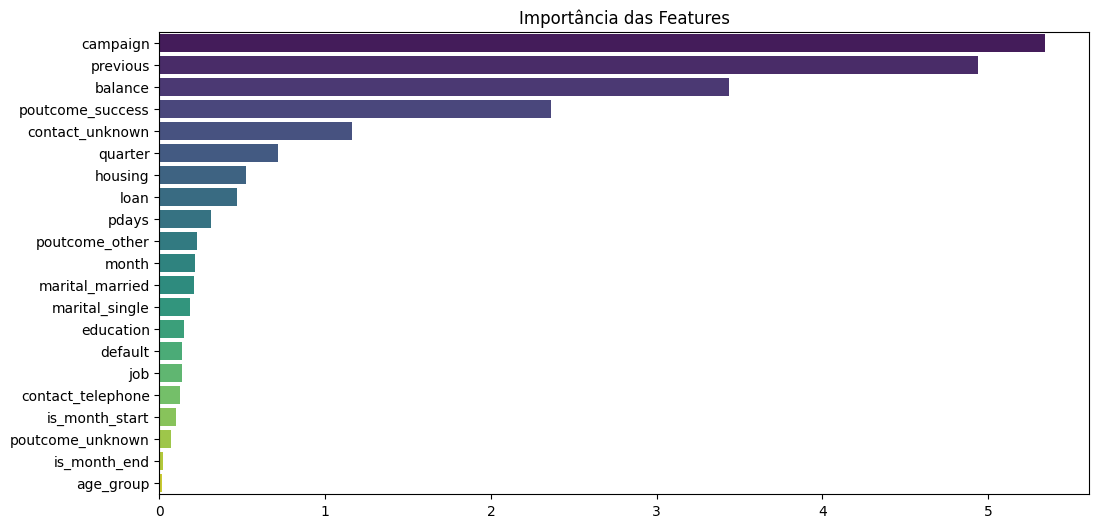

In [30]:
# feature importance (apenas para modelos que suportam essa funcionalidade)
def plot_feature_importance(model, feature_names: list):
    """Plota a importância das features para modelos que suportam essa funcionalidade."""
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    else:
        print("Modelo não suporta feature importance.")
        return

    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title("Importância das Features")
    sns.barplot(
        x=importances[indices],
        y=[feature_names[i] for i in indices],
        palette="viridis",
    )
# Plotando a importância das features para o melhor modelo otimizado
plot_feature_importance(best_model, X_train.columns.tolist())

# Old

In [31]:
df["job"] = df["job"].replace("unknown", "blue-collar")
df["education"] = df["education"].replace("unknown", "secondary")
df["contact"] = df["contact"].replace("unknown", "cellular")

#### Remover colunas

81.75% do atributo `poutcome` está como valor desconhecido, remover a coluna `poutcome`. Remover também a coluna `duration`.


In [32]:
df.drop(columns=["poutcome", "duration"], inplace=True)

#### Codificar variáveis alvo e `default`


In [33]:
df["y"] = df["y"].replace({"yes": 1, "no": 0})
df["default"] = df["default"].replace({"yes": 1, "no": 0})

#### Codificação de variáveis categóricas


In [34]:
# Listas de variáveis categóricas
nominal_features = ["job", "marital", "housing", "loan", "contact"]
ordinal_features = ["education", "month"]

# Codificação em variaveis nominais
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

# Codificação em variaveis categóricas ordinais
label_encoder = LabelEncoder()

for col in ordinal_features:
    df[col] = label_encoder.fit_transform(df[col])

df.replace({True: 1, False: 0}, inplace=True)

#### Normalização de variáveis numéricas

Analisar a distribuição das variáveis e verificar outliers.
`age`: assimétrica / `balance`: assimétrica / `campaign`: assimétrica / `pdays`: assimétrica / `previous` : assimétrica
Há uma distribuição assimétrica, fazer uma normalização com MinMaxScaler.


In [35]:
# Criar o normalizador das variaveis numéricas
scaler = MinMaxScaler()
# Aplicar normalização a todas as variáveis assimétricas
cols_to_normalize = ["age", "balance", "campaign", "pdays", "previous", "day"]
for col in cols_to_normalize:
    df[f"{col}_normalizado"] = scaler.fit_transform(df[[col]])

### Análise exploratória e visualização

#### Histograma idade MinMaxScaler

Comparação antes e depois do MinMaxScaler para a variável `age`.


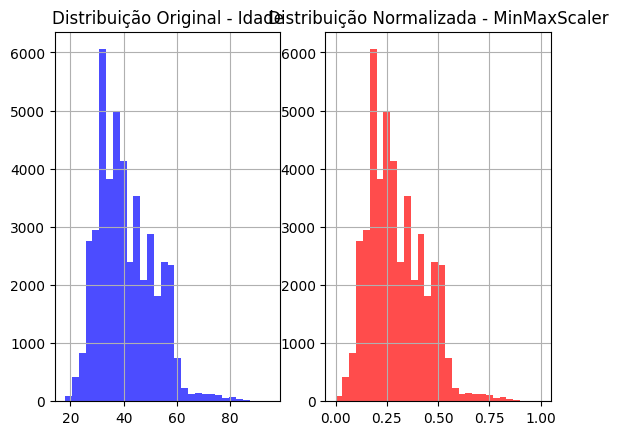

In [36]:
plt.subplot(1, 2, 1)
df["age"].hist(bins=30, alpha=0.7, color="b")
plt.title("Distribuição Original - Idade")
plt.subplot(1, 2, 2)
df["age_normalizado"].hist(bins=30, alpha=0.7, color="r")
plt.title("Distribuição Normalizada - MinMaxScaler")
plt.show()

#### Analisar outliers `balance`


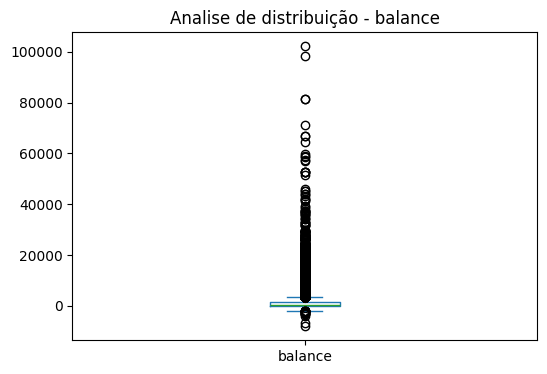

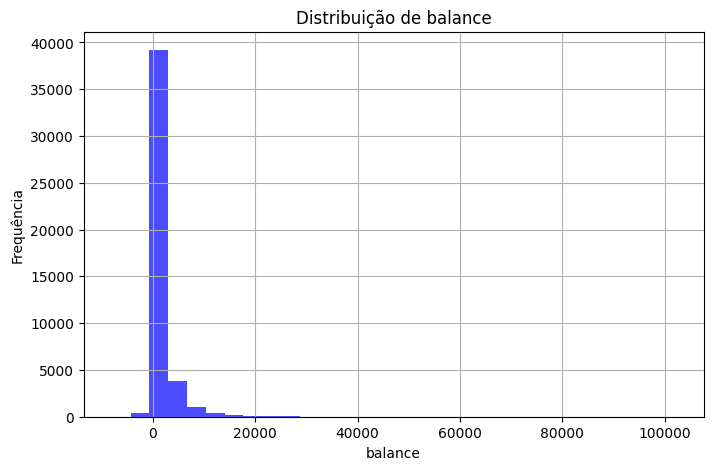

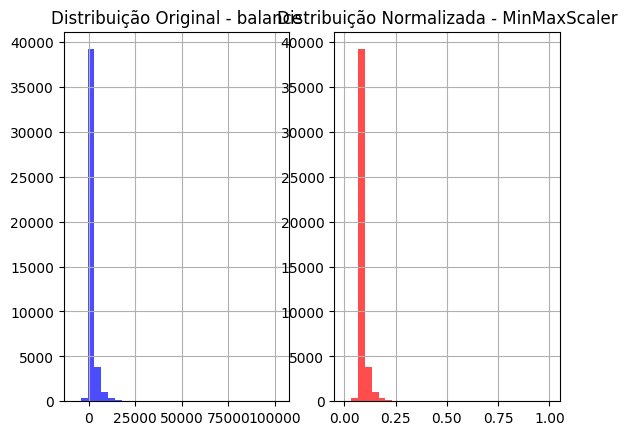

In [37]:
# Boxplot balance:
df["balance"].plot(kind="box", figsize=(6, 4))
plt.title("Analise de distribuição - balance")
plt.show()
# Histograma balance:
df["balance"].hist(bins=30, figsize=(8, 5), alpha=0.7, color="b")
plt.title("Distribuição de balance")
plt.xlabel("balance")
plt.ylabel("Frequência")
plt.show()

# Comparação antes e depois do MinMaxScaler
plt.subplot(1, 2, 1)
df["balance"].hist(bins=30, alpha=0.7, color="b")
plt.title("Distribuição Original - balance")
plt.subplot(1, 2, 2)
df["balance_normalizado"].hist(bins=30, alpha=0.7, color="r")
plt.title("Distribuição Normalizada - MinMaxScaler")
plt.show()

#### Analisar outliers `day`


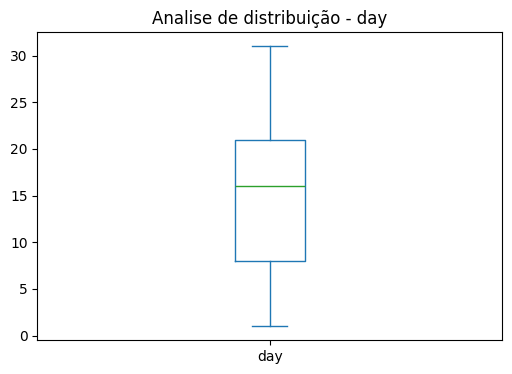

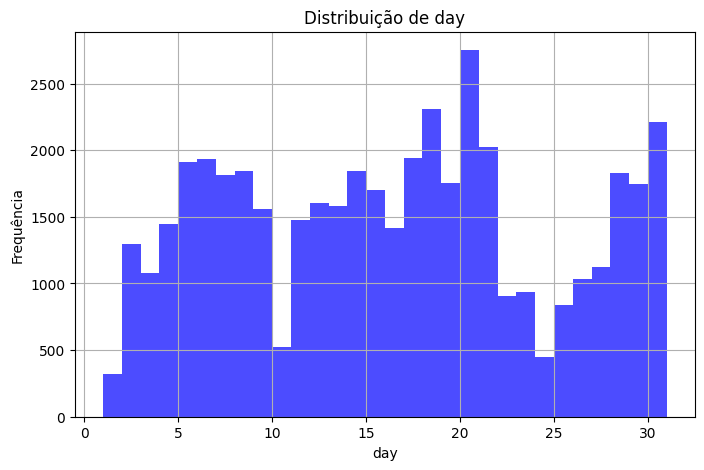

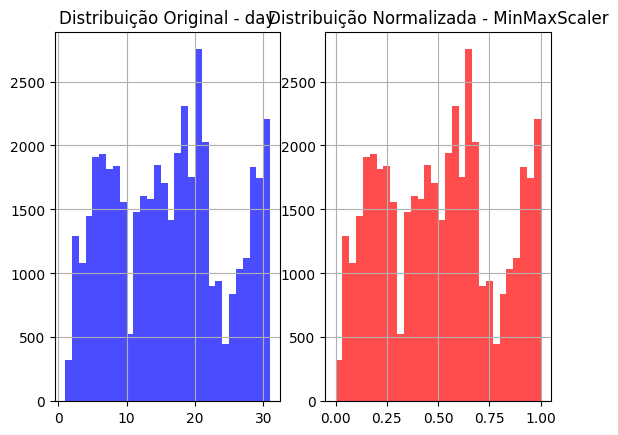

In [38]:
# Boxplot day:
df["day"].plot(kind="box", figsize=(6, 4))
plt.title("Analise de distribuição - day")
plt.show()
# Histograma balance:
df["day"].hist(bins=30, figsize=(8, 5), alpha=0.7, color="b")
plt.title("Distribuição de day")
plt.xlabel("day")
plt.ylabel("Frequência")
plt.show()
# Comparação antes e depois do MinMaxScaler
plt.subplot(1, 2, 1)
df["day"].hist(bins=30, alpha=0.7, color="b")
plt.title("Distribuição Original - day")
plt.subplot(1, 2, 2)
df["day_normalizado"].hist(bins=30, alpha=0.7, color="r")
plt.title("Distribuição Normalizada - MinMaxScaler")
plt.show()

#### Analisar outliers `pdays`


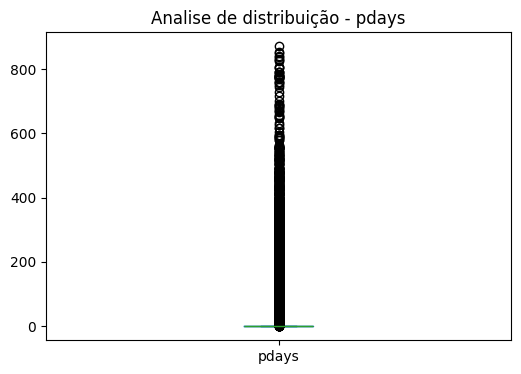

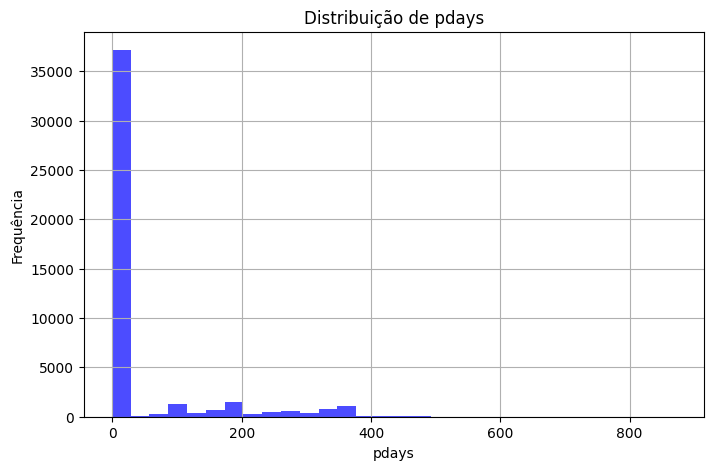

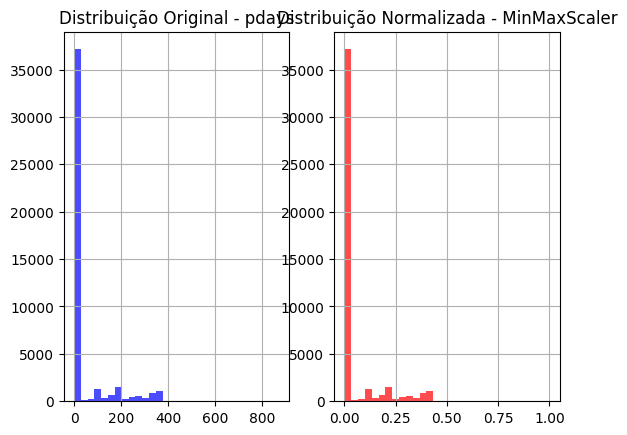

In [39]:
# Boxplot day:
df["pdays"].plot(kind="box", figsize=(6, 4))
plt.title("Analise de distribuição - pdays")
plt.show()
# Histograma balance:
df["pdays"].hist(bins=30, figsize=(8, 5), alpha=0.7, color="b")
plt.title("Distribuição de pdays")
plt.xlabel("pdays")
plt.ylabel("Frequência")
plt.show()
# Comparação antes e depois do MinMaxScaler
plt.subplot(1, 2, 1)
df["pdays"].hist(bins=30, alpha=0.7, color="b")
plt.title("Distribuição Original - pdays")
plt.subplot(1, 2, 2)
df["pdays_normalizado"].hist(bins=30, alpha=0.7, color="r")
plt.title("Distribuição Normalizada - MinMaxScaler")
plt.show()

#### Analisar outliers `previous`


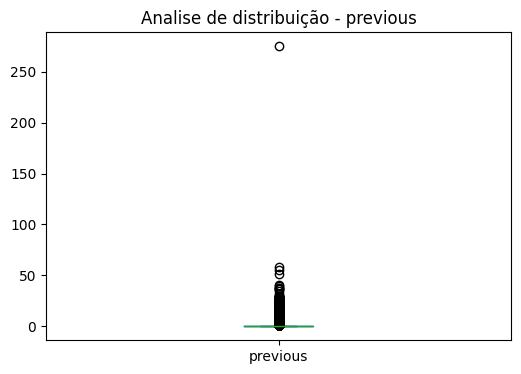

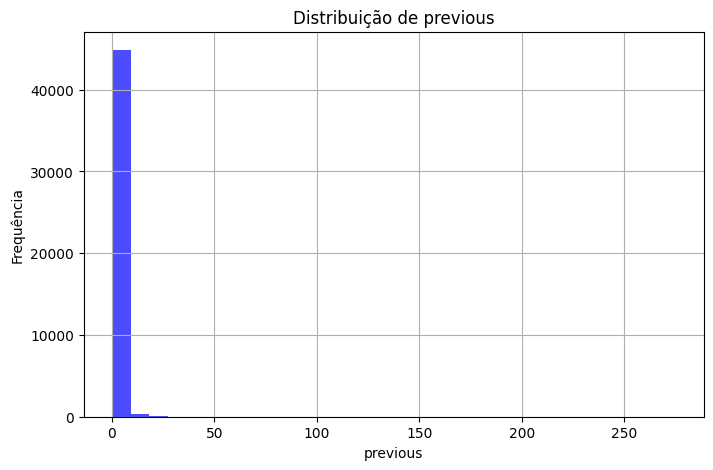

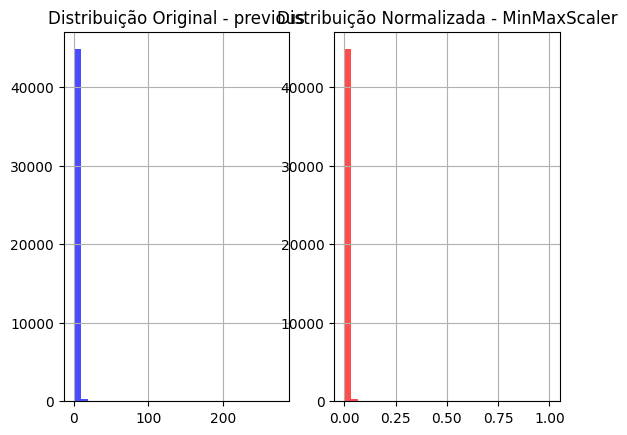

In [40]:
# Boxplot previous:
df["previous"].plot(kind="box", figsize=(6, 4))
plt.title("Analise de distribuição - previous")
plt.show()
# Histograma balance:
df["previous"].hist(bins=30, figsize=(8, 5), alpha=0.7, color="b")
plt.title("Distribuição de previous")
plt.xlabel("previous")
plt.ylabel("Frequência")
plt.show()
# Comparação antes e depois do MinMaxScaler
plt.subplot(1, 2, 1)
df["previous"].hist(bins=30, alpha=0.7, color="b")
plt.title("Distribuição Original - previous")
plt.subplot(1, 2, 2)
df["previous_normalizado"].hist(bins=30, alpha=0.7, color="r")
plt.title("Distribuição Normalizada - MinMaxScaler")
plt.show()

### Preparação dos dados para o modelo

- Realizar a divisão de dados de treino e teste e analise da distribuição da variável alvo;
- Há um desbalanceamento na variavel `y`, então será usada a técnica de balanceamento SMOTE;
- Usar as colunas normalizadas de `age`,`balance`, `day`, `pdays`, `previous`, `campaign` e remover as originais do conjunto de features `X`.


In [41]:
# Definir X (features) e y (variável alvo)
X = df.drop(columns=["y", "age", "balance", "day", "pdays", "previous", "campaign"])
y = df["y"]
# Divisão treino/teste com estratificação (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Criar objeto SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Treino com XGBoost


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores hiperparâmetros: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores hiperparâmetros (dados balanceados): {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Acurácia no conjunto de teste: 0.89

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.55      0.27      0.36      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.62      0.65      9043
weighted avg       0.87      0.89      0.87      9043



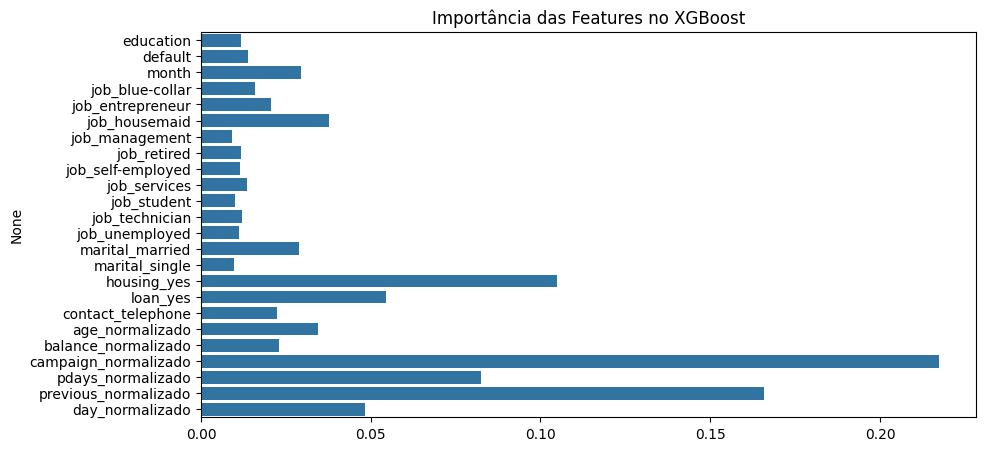

In [42]:
# Definição do grid de hiperparâmetros para otimização do modelo
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "colsample_bytree": [0.8, 1.0],
}

# GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(
    XGBClassifier(), param_grid, scoring="accuracy", cv=5, verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)
# Melhor conjunto de hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)

# GridSearchCV para otimizar XGBoost com dados balanceados
grid_search_bal = GridSearchCV(
    XGBClassifier(), param_grid, scoring="accuracy", cv=5, verbose=1, n_jobs=-1
)
grid_search_bal.fit(X_train_bal, y_train_bal)
print("Melhores hiperparâmetros (dados balanceados):", grid_search_bal.best_params_)

# Treinar modelo final com melhores hiperparâmetros (usando dados balanceados)
best_model = XGBClassifier(**grid_search_bal.best_params_)
best_model.fit(X_train_bal, y_train_bal)

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Plotar a importância das features
plt.figure(figsize=(10, 5))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title("Importância das Features no XGBoost")
plt.show()

### Treino com Arvore de Decisão


No caso da arvore de decisão decidimos utilizar o balanceamento automático no grid de parametro já que apresentou um melhor resultado, ignoramos os balanceamentos do SMOTE


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Melhores hiperparâmetros: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}
Acurácia no conjunto de teste: 0.89

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.54      0.16      0.25      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.57      0.59      9043
weighted avg       0.86      0.89      0.86      9043



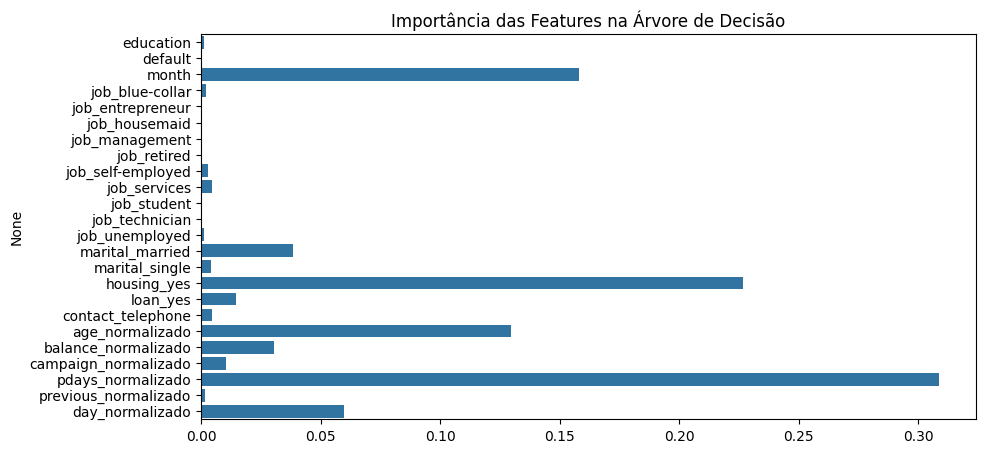

In [43]:
# Definição do grid de hiperparâmetros para otimização do modelo
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"],  # Balancemento Y
}

# GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(
    DecisionTreeClassifier(), param_grid, scoring="accuracy", cv=5, verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Melhor conjunto de hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Treinar modelo final com melhores hiperparâmetros
best_model = DecisionTreeClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Plotar a importância das features
plt.figure(figsize=(10, 5))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title("Importância das Features na Árvore de Decisão")
plt.show()

### Treino com Regressão Logística


No caso da regressão logística decidimos utilizar o balanceamento automático no grid de parametro já que apresentou um melhor resultado, ignoramos os balanceamentos do SMOTE


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Acurácia no conjunto de teste: 0.65

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.65      0.76      7985
           1       0.20      0.66      0.31      1058

    accuracy                           0.65      9043
   macro avg       0.57      0.66      0.54      9043
weighted avg       0.85      0.65      0.71      9043



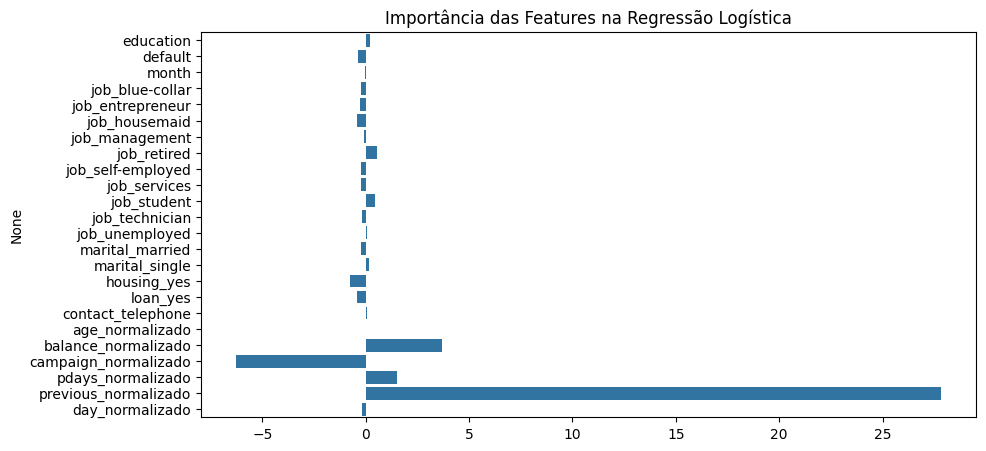

In [44]:
# Definição do grid de hiperparâmetros para otimização do modelo
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularização
    "penalty": ["l1", "l2"],  # Tipo de penalização
    "solver": ["liblinear", "saga"],  # Solvers
    "class_weight": ["balanced"],  # Balanceamento
}

# GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

# Melhor conjunto de hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Treinar modelo final com melhores hiperparâmetros
best_model = LogisticRegression(**grid_search.best_params_, max_iter=1000)
best_model.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Plotar a importância das features (coeficientes)
plt.figure(figsize=(10, 5))
sns.barplot(x=best_model.coef_.flatten(), y=X.columns)
plt.title("Importância das Features na Regressão Logística")
plt.show()